

##  Create the best autoencoder for the three meter dataset you can (best measured by MAE, more info in file), noting that the network must have at least one layer with less than half the number of datapoints rounded down

* Reasonable hyperparameters are all that is needed, please describe the optimization process in your writeup and do not make the hyperparameter search run by default
 






In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.utils.data as data_utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# !pip install torchsummary 
# from torchsummary import summary
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

torch.backends.cudnn.benchmark=True

# Loading the Training and Testing Data using Data Loader 

In [2]:
# Loading the Training and Testing Data
X = pd.read_csv('./Three Meter/data.csv')
X = np.array(X)

## Normalizing  the data using the Formula (x-xmin/(xmax-xmin)) across each column.

In [3]:
# # Normalizing the data by using the Formula (x-xmin/(xmax-xmin))
normX=(X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))

In [4]:
# Splitting the Data into Training and Test Data    trainImages.max(axis=0)
X_train, X_test = train_test_split(normX, test_size=0.15, shuffle = True)

# batch_size
batch = 64

# Train Data Loader
train = data_utils.TensorDataset(torch.from_numpy(X_train).float(),torch.from_numpy(X_train).float())
train_loader = data_utils.DataLoader(train, batch_size=batch, shuffle=True)

# Test Data loader
test = data_utils.TensorDataset(torch.from_numpy(X_test).float(),torch.from_numpy(X_test).float())
test_loader = data_utils.DataLoader(test,batch_size=batch)



# Showing the Training Data after Normalizing

In [5]:
# Preview the training data
for batch_idx, (data,label) in enumerate(train_loader):
    print("Training Data")
    print(data[0])
    print(label[0])
    break
    

Training Data
tensor([0.1232, 0.3925, 0.5646, 0.6845, 0.3358, 0.5616, 0.5690, 0.5646, 0.5468,
        0.5773, 0.5374, 0.5512, 0.5997, 0.7623, 0.7441, 0.4653, 0.3989, 0.4630,
        0.4377, 0.4034, 0.2792, 0.2182, 0.2593, 0.3960, 0.5524, 0.7343, 0.7527,
        0.5471, 0.4767, 0.4435, 0.5328, 0.5344, 0.7390])
tensor([0.1232, 0.3925, 0.5646, 0.6845, 0.3358, 0.5616, 0.5690, 0.5646, 0.5468,
        0.5773, 0.5374, 0.5512, 0.5997, 0.7623, 0.7441, 0.4653, 0.3989, 0.4630,
        0.4377, 0.4034, 0.2792, 0.2182, 0.2593, 0.3960, 0.5524, 0.7343, 0.7527,
        0.5471, 0.4767, 0.4435, 0.5328, 0.5344, 0.7390])


## Defining Convolution Neural Network

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
#             nn.Linear(33, 128),
#             nn.ReLU(True),
            nn.Linear(33, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12))
#             nn.ReLU(True),
#             nn.Linear(12, 3)) # Bottle Neck is at 3 neurons, which is 11 times less than the input
        self.decoder = nn.Sequential(
#             nn.Linear(3, 12),
#             nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 33))
#             nn.ReLU(True),
#             nn.Linear(128, 33),
#             nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
net = Net()
net.to(device)

Net(
  (encoder): Sequential(
    (0): Linear(in_features=33, out_features=64, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=64, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=64, out_features=33, bias=True)
  )
)

In [7]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
# summary(net,input_size = (1,33),batch_size=batch)

##  Define a Loss function and optimizer  
* Loss Function taken is MAE loss or L1loss. 
* The loss function is divided by batch size to get the coorect loss reading. (as the function sums uo the loss).
* Different Optimizations were tried out as seen below:



In [8]:
import torch.optim as optim

criterion = nn.L1Loss()
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9,weight_decay = 5e-4)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

In [9]:
# output = net(data)
#         print(target.dtype,output.dtype)
# loss = criterion(output, output)
# loss.backward()
# optimizer.step()
# torch.sum(output==target)


In [10]:
data[0].shape

torch.Size([33])


## Training and Testing

In [11]:
def train(model, train_loader, optimizer, epoch,device):
    model.train()
    training_loss = 0
    lo = []
    for batch_idx, (data,target) in enumerate(train_loader):
        data,target = data.to(device), target.to(device)

        #=====Forward====
        output = model(data)
        loss = criterion(output, target)
         #=====Backward====
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #=== Loss Calculation
        lo.append(loss.item()/batch)
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/batch))
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    model.eval()
    test_loss = 0
    testlo = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #== Forward===
            output = model(data)
            test_loss = criterion(output, target)
            #=== Test loss====
            testlo.append(test_loss.item()/batch)
    val_loss.append(np.mean(testlo))
    print('\nTest set: Average loss: {:.4f}\n'.format(np.mean(testlo)))

In [12]:
device

device(type='cuda', index=0)

# Training the Model

In [13]:
epochs = 100
for epoch in range(1, epochs + 1):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 1 [0/118320 (0%)]	Loss: 0.007270
Train Epoch: 1 [640/118320 (1%)]	Loss: 0.005453
Train Epoch: 1 [1280/118320 (1%)]	Loss: 0.003158
Train Epoch: 1 [1920/118320 (2%)]	Loss: 0.002458
Train Epoch: 1 [2560/118320 (2%)]	Loss: 0.002183
Train Epoch: 1 [3200/118320 (3%)]	Loss: 0.002133
Train Epoch: 1 [3840/118320 (3%)]	Loss: 0.002101
Train Epoch: 1 [4480/118320 (4%)]	Loss: 0.002113
Train Epoch: 1 [5120/118320 (4%)]	Loss: 0.002017
Train Epoch: 1 [5760/118320 (5%)]	Loss: 0.002036
Train Epoch: 1 [6400/118320 (5%)]	Loss: 0.001957
Train Epoch: 1 [7040/118320 (6%)]	Loss: 0.001813
Train Epoch: 1 [7680/118320 (6%)]	Loss: 0.001740
Train Epoch: 1 [8320/118320 (7%)]	Loss: 0.001614
Train Epoch: 1 [8960/118320 (8%)]	Loss: 0.001446
Train Epoch: 1 [9600/118320 (8%)]	Loss: 0.001316
Train Epoch: 1 [10240/118320 (9%)]	Loss: 0.001200
Train Epoch: 1 [10880/118320 (9%)]	Loss: 0.001197
Train Epoch: 1 [11520/118320 (10%)]	Loss: 0.001150
Train Epoch: 1 [12160/118320 (10%)]	Loss: 0.001172
Train Epoch: 1 [12

Train Epoch: 1 [103680/118320 (88%)]	Loss: 0.000715
Train Epoch: 1 [104320/118320 (88%)]	Loss: 0.000755
Train Epoch: 1 [104960/118320 (89%)]	Loss: 0.000708
Train Epoch: 1 [105600/118320 (89%)]	Loss: 0.000717
Train Epoch: 1 [106240/118320 (90%)]	Loss: 0.000739
Train Epoch: 1 [106880/118320 (90%)]	Loss: 0.000738
Train Epoch: 1 [107520/118320 (91%)]	Loss: 0.000730
Train Epoch: 1 [108160/118320 (91%)]	Loss: 0.000714
Train Epoch: 1 [108800/118320 (92%)]	Loss: 0.000732
Train Epoch: 1 [109440/118320 (92%)]	Loss: 0.000704
Train Epoch: 1 [110080/118320 (93%)]	Loss: 0.000726
Train Epoch: 1 [110720/118320 (94%)]	Loss: 0.000690
Train Epoch: 1 [111360/118320 (94%)]	Loss: 0.000716
Train Epoch: 1 [112000/118320 (95%)]	Loss: 0.000739
Train Epoch: 1 [112640/118320 (95%)]	Loss: 0.000725
Train Epoch: 1 [113280/118320 (96%)]	Loss: 0.000703
Train Epoch: 1 [113920/118320 (96%)]	Loss: 0.000717
Train Epoch: 1 [114560/118320 (97%)]	Loss: 0.000687
Train Epoch: 1 [115200/118320 (97%)]	Loss: 0.000686
Train Epoch:

Train Epoch: 2 [88960/118320 (75%)]	Loss: 0.000684
Train Epoch: 2 [89600/118320 (76%)]	Loss: 0.000695
Train Epoch: 2 [90240/118320 (76%)]	Loss: 0.000679
Train Epoch: 2 [90880/118320 (77%)]	Loss: 0.000669
Train Epoch: 2 [91520/118320 (77%)]	Loss: 0.000685
Train Epoch: 2 [92160/118320 (78%)]	Loss: 0.000709
Train Epoch: 2 [92800/118320 (78%)]	Loss: 0.000676
Train Epoch: 2 [93440/118320 (79%)]	Loss: 0.000707
Train Epoch: 2 [94080/118320 (80%)]	Loss: 0.000692
Train Epoch: 2 [94720/118320 (80%)]	Loss: 0.000662
Train Epoch: 2 [95360/118320 (81%)]	Loss: 0.000685
Train Epoch: 2 [96000/118320 (81%)]	Loss: 0.000690
Train Epoch: 2 [96640/118320 (82%)]	Loss: 0.000691
Train Epoch: 2 [97280/118320 (82%)]	Loss: 0.000681
Train Epoch: 2 [97920/118320 (83%)]	Loss: 0.000676
Train Epoch: 2 [98560/118320 (83%)]	Loss: 0.000664
Train Epoch: 2 [99200/118320 (84%)]	Loss: 0.000675
Train Epoch: 2 [99840/118320 (84%)]	Loss: 0.000661
Train Epoch: 2 [100480/118320 (85%)]	Loss: 0.000685
Train Epoch: 2 [101120/118320 

Train Epoch: 3 [76160/118320 (64%)]	Loss: 0.000671
Train Epoch: 3 [76800/118320 (65%)]	Loss: 0.000662
Train Epoch: 3 [77440/118320 (65%)]	Loss: 0.000678
Train Epoch: 3 [78080/118320 (66%)]	Loss: 0.000665
Train Epoch: 3 [78720/118320 (67%)]	Loss: 0.000646
Train Epoch: 3 [79360/118320 (67%)]	Loss: 0.000650
Train Epoch: 3 [80000/118320 (68%)]	Loss: 0.000683
Train Epoch: 3 [80640/118320 (68%)]	Loss: 0.000684
Train Epoch: 3 [81280/118320 (69%)]	Loss: 0.000669
Train Epoch: 3 [81920/118320 (69%)]	Loss: 0.000656
Train Epoch: 3 [82560/118320 (70%)]	Loss: 0.000676
Train Epoch: 3 [83200/118320 (70%)]	Loss: 0.000678
Train Epoch: 3 [83840/118320 (71%)]	Loss: 0.000621
Train Epoch: 3 [84480/118320 (71%)]	Loss: 0.000667
Train Epoch: 3 [85120/118320 (72%)]	Loss: 0.000668
Train Epoch: 3 [85760/118320 (72%)]	Loss: 0.000656
Train Epoch: 3 [86400/118320 (73%)]	Loss: 0.000625
Train Epoch: 3 [87040/118320 (74%)]	Loss: 0.000684
Train Epoch: 3 [87680/118320 (74%)]	Loss: 0.000632
Train Epoch: 3 [88320/118320 (7

Train Epoch: 4 [62720/118320 (53%)]	Loss: 0.000691
Train Epoch: 4 [63360/118320 (54%)]	Loss: 0.000680
Train Epoch: 4 [64000/118320 (54%)]	Loss: 0.000648
Train Epoch: 4 [64640/118320 (55%)]	Loss: 0.000666
Train Epoch: 4 [65280/118320 (55%)]	Loss: 0.000689
Train Epoch: 4 [65920/118320 (56%)]	Loss: 0.000644
Train Epoch: 4 [66560/118320 (56%)]	Loss: 0.000642
Train Epoch: 4 [67200/118320 (57%)]	Loss: 0.000659
Train Epoch: 4 [67840/118320 (57%)]	Loss: 0.000665
Train Epoch: 4 [68480/118320 (58%)]	Loss: 0.000681
Train Epoch: 4 [69120/118320 (58%)]	Loss: 0.000641
Train Epoch: 4 [69760/118320 (59%)]	Loss: 0.000658
Train Epoch: 4 [70400/118320 (59%)]	Loss: 0.000635
Train Epoch: 4 [71040/118320 (60%)]	Loss: 0.000650
Train Epoch: 4 [71680/118320 (61%)]	Loss: 0.000663
Train Epoch: 4 [72320/118320 (61%)]	Loss: 0.000662
Train Epoch: 4 [72960/118320 (62%)]	Loss: 0.000675
Train Epoch: 4 [73600/118320 (62%)]	Loss: 0.000661
Train Epoch: 4 [74240/118320 (63%)]	Loss: 0.000637
Train Epoch: 4 [74880/118320 (6

Train Epoch: 5 [48640/118320 (41%)]	Loss: 0.000665
Train Epoch: 5 [49280/118320 (42%)]	Loss: 0.000631
Train Epoch: 5 [49920/118320 (42%)]	Loss: 0.000648
Train Epoch: 5 [50560/118320 (43%)]	Loss: 0.000638
Train Epoch: 5 [51200/118320 (43%)]	Loss: 0.000677
Train Epoch: 5 [51840/118320 (44%)]	Loss: 0.000647
Train Epoch: 5 [52480/118320 (44%)]	Loss: 0.000674
Train Epoch: 5 [53120/118320 (45%)]	Loss: 0.000651
Train Epoch: 5 [53760/118320 (45%)]	Loss: 0.000647
Train Epoch: 5 [54400/118320 (46%)]	Loss: 0.000669
Train Epoch: 5 [55040/118320 (47%)]	Loss: 0.000628
Train Epoch: 5 [55680/118320 (47%)]	Loss: 0.000659
Train Epoch: 5 [56320/118320 (48%)]	Loss: 0.000642
Train Epoch: 5 [56960/118320 (48%)]	Loss: 0.000644
Train Epoch: 5 [57600/118320 (49%)]	Loss: 0.000657
Train Epoch: 5 [58240/118320 (49%)]	Loss: 0.000654
Train Epoch: 5 [58880/118320 (50%)]	Loss: 0.000648
Train Epoch: 5 [59520/118320 (50%)]	Loss: 0.000648
Train Epoch: 5 [60160/118320 (51%)]	Loss: 0.000647
Train Epoch: 5 [60800/118320 (5

Train Epoch: 6 [33920/118320 (29%)]	Loss: 0.000632
Train Epoch: 6 [34560/118320 (29%)]	Loss: 0.000657
Train Epoch: 6 [35200/118320 (30%)]	Loss: 0.000624
Train Epoch: 6 [35840/118320 (30%)]	Loss: 0.000654
Train Epoch: 6 [36480/118320 (31%)]	Loss: 0.000639
Train Epoch: 6 [37120/118320 (31%)]	Loss: 0.000648
Train Epoch: 6 [37760/118320 (32%)]	Loss: 0.000667
Train Epoch: 6 [38400/118320 (32%)]	Loss: 0.000635
Train Epoch: 6 [39040/118320 (33%)]	Loss: 0.000651
Train Epoch: 6 [39680/118320 (34%)]	Loss: 0.000650
Train Epoch: 6 [40320/118320 (34%)]	Loss: 0.000629
Train Epoch: 6 [40960/118320 (35%)]	Loss: 0.000623
Train Epoch: 6 [41600/118320 (35%)]	Loss: 0.000660
Train Epoch: 6 [42240/118320 (36%)]	Loss: 0.000684
Train Epoch: 6 [42880/118320 (36%)]	Loss: 0.000626
Train Epoch: 6 [43520/118320 (37%)]	Loss: 0.000611
Train Epoch: 6 [44160/118320 (37%)]	Loss: 0.000635
Train Epoch: 6 [44800/118320 (38%)]	Loss: 0.000655
Train Epoch: 6 [45440/118320 (38%)]	Loss: 0.000623
Train Epoch: 6 [46080/118320 (3

Train Epoch: 7 [20480/118320 (17%)]	Loss: 0.000633
Train Epoch: 7 [21120/118320 (18%)]	Loss: 0.000655
Train Epoch: 7 [21760/118320 (18%)]	Loss: 0.000625
Train Epoch: 7 [22400/118320 (19%)]	Loss: 0.000654
Train Epoch: 7 [23040/118320 (19%)]	Loss: 0.000627
Train Epoch: 7 [23680/118320 (20%)]	Loss: 0.000649
Train Epoch: 7 [24320/118320 (21%)]	Loss: 0.000661
Train Epoch: 7 [24960/118320 (21%)]	Loss: 0.000658
Train Epoch: 7 [25600/118320 (22%)]	Loss: 0.000662
Train Epoch: 7 [26240/118320 (22%)]	Loss: 0.000626
Train Epoch: 7 [26880/118320 (23%)]	Loss: 0.000645
Train Epoch: 7 [27520/118320 (23%)]	Loss: 0.000627
Train Epoch: 7 [28160/118320 (24%)]	Loss: 0.000617
Train Epoch: 7 [28800/118320 (24%)]	Loss: 0.000647
Train Epoch: 7 [29440/118320 (25%)]	Loss: 0.000657
Train Epoch: 7 [30080/118320 (25%)]	Loss: 0.000655
Train Epoch: 7 [30720/118320 (26%)]	Loss: 0.000642
Train Epoch: 7 [31360/118320 (27%)]	Loss: 0.000635
Train Epoch: 7 [32000/118320 (27%)]	Loss: 0.000649
Train Epoch: 7 [32640/118320 (2

Train Epoch: 8 [7040/118320 (6%)]	Loss: 0.000656
Train Epoch: 8 [7680/118320 (6%)]	Loss: 0.000623
Train Epoch: 8 [8320/118320 (7%)]	Loss: 0.000642
Train Epoch: 8 [8960/118320 (8%)]	Loss: 0.000639
Train Epoch: 8 [9600/118320 (8%)]	Loss: 0.000638
Train Epoch: 8 [10240/118320 (9%)]	Loss: 0.000640
Train Epoch: 8 [10880/118320 (9%)]	Loss: 0.000662
Train Epoch: 8 [11520/118320 (10%)]	Loss: 0.000618
Train Epoch: 8 [12160/118320 (10%)]	Loss: 0.000667
Train Epoch: 8 [12800/118320 (11%)]	Loss: 0.000662
Train Epoch: 8 [13440/118320 (11%)]	Loss: 0.000648
Train Epoch: 8 [14080/118320 (12%)]	Loss: 0.000642
Train Epoch: 8 [14720/118320 (12%)]	Loss: 0.000626
Train Epoch: 8 [15360/118320 (13%)]	Loss: 0.000649
Train Epoch: 8 [16000/118320 (14%)]	Loss: 0.000620
Train Epoch: 8 [16640/118320 (14%)]	Loss: 0.000651
Train Epoch: 8 [17280/118320 (15%)]	Loss: 0.000641
Train Epoch: 8 [17920/118320 (15%)]	Loss: 0.000619
Train Epoch: 8 [18560/118320 (16%)]	Loss: 0.000641
Train Epoch: 8 [19200/118320 (16%)]	Loss: 0

Train Epoch: 8 [110080/118320 (93%)]	Loss: 0.000645
Train Epoch: 8 [110720/118320 (94%)]	Loss: 0.000636
Train Epoch: 8 [111360/118320 (94%)]	Loss: 0.000649
Train Epoch: 8 [112000/118320 (95%)]	Loss: 0.000661
Train Epoch: 8 [112640/118320 (95%)]	Loss: 0.000600
Train Epoch: 8 [113280/118320 (96%)]	Loss: 0.000631
Train Epoch: 8 [113920/118320 (96%)]	Loss: 0.000635
Train Epoch: 8 [114560/118320 (97%)]	Loss: 0.000662
Train Epoch: 8 [115200/118320 (97%)]	Loss: 0.000665
Train Epoch: 8 [115840/118320 (98%)]	Loss: 0.000617
Train Epoch: 8 [116480/118320 (98%)]	Loss: 0.000628
Train Epoch: 8 [117120/118320 (99%)]	Loss: 0.000617
Train Epoch: 8 [117760/118320 (100%)]	Loss: 0.000626

Test set: Average loss: 0.0006

Train Epoch: 9 [0/118320 (0%)]	Loss: 0.000648
Train Epoch: 9 [640/118320 (1%)]	Loss: 0.000675
Train Epoch: 9 [1280/118320 (1%)]	Loss: 0.000639
Train Epoch: 9 [1920/118320 (2%)]	Loss: 0.000643
Train Epoch: 9 [2560/118320 (2%)]	Loss: 0.000624
Train Epoch: 9 [3200/118320 (3%)]	Loss: 0.000658


Train Epoch: 9 [98560/118320 (83%)]	Loss: 0.000621
Train Epoch: 9 [99200/118320 (84%)]	Loss: 0.000624
Train Epoch: 9 [99840/118320 (84%)]	Loss: 0.000633
Train Epoch: 9 [100480/118320 (85%)]	Loss: 0.000658
Train Epoch: 9 [101120/118320 (85%)]	Loss: 0.000675
Train Epoch: 9 [101760/118320 (86%)]	Loss: 0.000623
Train Epoch: 9 [102400/118320 (87%)]	Loss: 0.000695
Train Epoch: 9 [103040/118320 (87%)]	Loss: 0.000631
Train Epoch: 9 [103680/118320 (88%)]	Loss: 0.000640
Train Epoch: 9 [104320/118320 (88%)]	Loss: 0.000644
Train Epoch: 9 [104960/118320 (89%)]	Loss: 0.000628
Train Epoch: 9 [105600/118320 (89%)]	Loss: 0.000629
Train Epoch: 9 [106240/118320 (90%)]	Loss: 0.000629
Train Epoch: 9 [106880/118320 (90%)]	Loss: 0.000626
Train Epoch: 9 [107520/118320 (91%)]	Loss: 0.000653
Train Epoch: 9 [108160/118320 (91%)]	Loss: 0.000639
Train Epoch: 9 [108800/118320 (92%)]	Loss: 0.000642
Train Epoch: 9 [109440/118320 (92%)]	Loss: 0.000650
Train Epoch: 9 [110080/118320 (93%)]	Loss: 0.000617
Train Epoch: 9 

Train Epoch: 10 [84480/118320 (71%)]	Loss: 0.000644
Train Epoch: 10 [85120/118320 (72%)]	Loss: 0.000633
Train Epoch: 10 [85760/118320 (72%)]	Loss: 0.000640
Train Epoch: 10 [86400/118320 (73%)]	Loss: 0.000660
Train Epoch: 10 [87040/118320 (74%)]	Loss: 0.000621
Train Epoch: 10 [87680/118320 (74%)]	Loss: 0.000649
Train Epoch: 10 [88320/118320 (75%)]	Loss: 0.000634
Train Epoch: 10 [88960/118320 (75%)]	Loss: 0.000641
Train Epoch: 10 [89600/118320 (76%)]	Loss: 0.000643
Train Epoch: 10 [90240/118320 (76%)]	Loss: 0.000670
Train Epoch: 10 [90880/118320 (77%)]	Loss: 0.000639
Train Epoch: 10 [91520/118320 (77%)]	Loss: 0.000659
Train Epoch: 10 [92160/118320 (78%)]	Loss: 0.000658
Train Epoch: 10 [92800/118320 (78%)]	Loss: 0.000680
Train Epoch: 10 [93440/118320 (79%)]	Loss: 0.000629
Train Epoch: 10 [94080/118320 (80%)]	Loss: 0.000646
Train Epoch: 10 [94720/118320 (80%)]	Loss: 0.000644
Train Epoch: 10 [95360/118320 (81%)]	Loss: 0.000638
Train Epoch: 10 [96000/118320 (81%)]	Loss: 0.000646
Train Epoch:

Train Epoch: 11 [70400/118320 (59%)]	Loss: 0.000611
Train Epoch: 11 [71040/118320 (60%)]	Loss: 0.000658
Train Epoch: 11 [71680/118320 (61%)]	Loss: 0.000631
Train Epoch: 11 [72320/118320 (61%)]	Loss: 0.000655
Train Epoch: 11 [72960/118320 (62%)]	Loss: 0.000628
Train Epoch: 11 [73600/118320 (62%)]	Loss: 0.000648
Train Epoch: 11 [74240/118320 (63%)]	Loss: 0.000640
Train Epoch: 11 [74880/118320 (63%)]	Loss: 0.000666
Train Epoch: 11 [75520/118320 (64%)]	Loss: 0.000675
Train Epoch: 11 [76160/118320 (64%)]	Loss: 0.000635
Train Epoch: 11 [76800/118320 (65%)]	Loss: 0.000614
Train Epoch: 11 [77440/118320 (65%)]	Loss: 0.000628
Train Epoch: 11 [78080/118320 (66%)]	Loss: 0.000661
Train Epoch: 11 [78720/118320 (67%)]	Loss: 0.000652
Train Epoch: 11 [79360/118320 (67%)]	Loss: 0.000634
Train Epoch: 11 [80000/118320 (68%)]	Loss: 0.000635
Train Epoch: 11 [80640/118320 (68%)]	Loss: 0.000640
Train Epoch: 11 [81280/118320 (69%)]	Loss: 0.000644
Train Epoch: 11 [81920/118320 (69%)]	Loss: 0.000635
Train Epoch:

Train Epoch: 12 [56320/118320 (48%)]	Loss: 0.000654
Train Epoch: 12 [56960/118320 (48%)]	Loss: 0.000637
Train Epoch: 12 [57600/118320 (49%)]	Loss: 0.000619
Train Epoch: 12 [58240/118320 (49%)]	Loss: 0.000653
Train Epoch: 12 [58880/118320 (50%)]	Loss: 0.000649
Train Epoch: 12 [59520/118320 (50%)]	Loss: 0.000623
Train Epoch: 12 [60160/118320 (51%)]	Loss: 0.000656
Train Epoch: 12 [60800/118320 (51%)]	Loss: 0.000612
Train Epoch: 12 [61440/118320 (52%)]	Loss: 0.000634
Train Epoch: 12 [62080/118320 (52%)]	Loss: 0.000617
Train Epoch: 12 [62720/118320 (53%)]	Loss: 0.000613
Train Epoch: 12 [63360/118320 (54%)]	Loss: 0.000636
Train Epoch: 12 [64000/118320 (54%)]	Loss: 0.000664
Train Epoch: 12 [64640/118320 (55%)]	Loss: 0.000650
Train Epoch: 12 [65280/118320 (55%)]	Loss: 0.000654
Train Epoch: 12 [65920/118320 (56%)]	Loss: 0.000635
Train Epoch: 12 [66560/118320 (56%)]	Loss: 0.000633
Train Epoch: 12 [67200/118320 (57%)]	Loss: 0.000637
Train Epoch: 12 [67840/118320 (57%)]	Loss: 0.000660
Train Epoch:

Train Epoch: 13 [42240/118320 (36%)]	Loss: 0.000625
Train Epoch: 13 [42880/118320 (36%)]	Loss: 0.000630
Train Epoch: 13 [43520/118320 (37%)]	Loss: 0.000642
Train Epoch: 13 [44160/118320 (37%)]	Loss: 0.000623
Train Epoch: 13 [44800/118320 (38%)]	Loss: 0.000631
Train Epoch: 13 [45440/118320 (38%)]	Loss: 0.000669
Train Epoch: 13 [46080/118320 (39%)]	Loss: 0.000645
Train Epoch: 13 [46720/118320 (39%)]	Loss: 0.000650
Train Epoch: 13 [47360/118320 (40%)]	Loss: 0.000653
Train Epoch: 13 [48000/118320 (41%)]	Loss: 0.000659
Train Epoch: 13 [48640/118320 (41%)]	Loss: 0.000639
Train Epoch: 13 [49280/118320 (42%)]	Loss: 0.000678
Train Epoch: 13 [49920/118320 (42%)]	Loss: 0.000661
Train Epoch: 13 [50560/118320 (43%)]	Loss: 0.000655
Train Epoch: 13 [51200/118320 (43%)]	Loss: 0.000664
Train Epoch: 13 [51840/118320 (44%)]	Loss: 0.000647
Train Epoch: 13 [52480/118320 (44%)]	Loss: 0.000625
Train Epoch: 13 [53120/118320 (45%)]	Loss: 0.000649
Train Epoch: 13 [53760/118320 (45%)]	Loss: 0.000640
Train Epoch:

Train Epoch: 14 [28160/118320 (24%)]	Loss: 0.000612
Train Epoch: 14 [28800/118320 (24%)]	Loss: 0.000642
Train Epoch: 14 [29440/118320 (25%)]	Loss: 0.000634
Train Epoch: 14 [30080/118320 (25%)]	Loss: 0.000653
Train Epoch: 14 [30720/118320 (26%)]	Loss: 0.000668
Train Epoch: 14 [31360/118320 (27%)]	Loss: 0.000654
Train Epoch: 14 [32000/118320 (27%)]	Loss: 0.000634
Train Epoch: 14 [32640/118320 (28%)]	Loss: 0.000632
Train Epoch: 14 [33280/118320 (28%)]	Loss: 0.000610
Train Epoch: 14 [33920/118320 (29%)]	Loss: 0.000645
Train Epoch: 14 [34560/118320 (29%)]	Loss: 0.000655
Train Epoch: 14 [35200/118320 (30%)]	Loss: 0.000645
Train Epoch: 14 [35840/118320 (30%)]	Loss: 0.000643
Train Epoch: 14 [36480/118320 (31%)]	Loss: 0.000657
Train Epoch: 14 [37120/118320 (31%)]	Loss: 0.000668
Train Epoch: 14 [37760/118320 (32%)]	Loss: 0.000661
Train Epoch: 14 [38400/118320 (32%)]	Loss: 0.000660
Train Epoch: 14 [39040/118320 (33%)]	Loss: 0.000665
Train Epoch: 14 [39680/118320 (34%)]	Loss: 0.000637
Train Epoch:

Train Epoch: 15 [14080/118320 (12%)]	Loss: 0.000648
Train Epoch: 15 [14720/118320 (12%)]	Loss: 0.000628
Train Epoch: 15 [15360/118320 (13%)]	Loss: 0.000633
Train Epoch: 15 [16000/118320 (14%)]	Loss: 0.000607
Train Epoch: 15 [16640/118320 (14%)]	Loss: 0.000617
Train Epoch: 15 [17280/118320 (15%)]	Loss: 0.000674
Train Epoch: 15 [17920/118320 (15%)]	Loss: 0.000641
Train Epoch: 15 [18560/118320 (16%)]	Loss: 0.000651
Train Epoch: 15 [19200/118320 (16%)]	Loss: 0.000663
Train Epoch: 15 [19840/118320 (17%)]	Loss: 0.000644
Train Epoch: 15 [20480/118320 (17%)]	Loss: 0.000645
Train Epoch: 15 [21120/118320 (18%)]	Loss: 0.000653
Train Epoch: 15 [21760/118320 (18%)]	Loss: 0.000675
Train Epoch: 15 [22400/118320 (19%)]	Loss: 0.000636
Train Epoch: 15 [23040/118320 (19%)]	Loss: 0.000630
Train Epoch: 15 [23680/118320 (20%)]	Loss: 0.000673
Train Epoch: 15 [24320/118320 (21%)]	Loss: 0.000656
Train Epoch: 15 [24960/118320 (21%)]	Loss: 0.000643
Train Epoch: 15 [25600/118320 (22%)]	Loss: 0.000651
Train Epoch:


Test set: Average loss: 0.0006

Train Epoch: 16 [0/118320 (0%)]	Loss: 0.000674
Train Epoch: 16 [640/118320 (1%)]	Loss: 0.000621
Train Epoch: 16 [1280/118320 (1%)]	Loss: 0.000632
Train Epoch: 16 [1920/118320 (2%)]	Loss: 0.000662
Train Epoch: 16 [2560/118320 (2%)]	Loss: 0.000646
Train Epoch: 16 [3200/118320 (3%)]	Loss: 0.000636
Train Epoch: 16 [3840/118320 (3%)]	Loss: 0.000628
Train Epoch: 16 [4480/118320 (4%)]	Loss: 0.000662
Train Epoch: 16 [5120/118320 (4%)]	Loss: 0.000635
Train Epoch: 16 [5760/118320 (5%)]	Loss: 0.000649
Train Epoch: 16 [6400/118320 (5%)]	Loss: 0.000645
Train Epoch: 16 [7040/118320 (6%)]	Loss: 0.000670
Train Epoch: 16 [7680/118320 (6%)]	Loss: 0.000635
Train Epoch: 16 [8320/118320 (7%)]	Loss: 0.000644
Train Epoch: 16 [8960/118320 (8%)]	Loss: 0.000659
Train Epoch: 16 [9600/118320 (8%)]	Loss: 0.000645
Train Epoch: 16 [10240/118320 (9%)]	Loss: 0.000642
Train Epoch: 16 [10880/118320 (9%)]	Loss: 0.000691
Train Epoch: 16 [11520/118320 (10%)]	Loss: 0.000642
Train Epoch: 16 [

Train Epoch: 16 [105600/118320 (89%)]	Loss: 0.000662
Train Epoch: 16 [106240/118320 (90%)]	Loss: 0.000629
Train Epoch: 16 [106880/118320 (90%)]	Loss: 0.000639
Train Epoch: 16 [107520/118320 (91%)]	Loss: 0.000651
Train Epoch: 16 [108160/118320 (91%)]	Loss: 0.000644
Train Epoch: 16 [108800/118320 (92%)]	Loss: 0.000671
Train Epoch: 16 [109440/118320 (92%)]	Loss: 0.000668
Train Epoch: 16 [110080/118320 (93%)]	Loss: 0.000663
Train Epoch: 16 [110720/118320 (94%)]	Loss: 0.000632
Train Epoch: 16 [111360/118320 (94%)]	Loss: 0.000656
Train Epoch: 16 [112000/118320 (95%)]	Loss: 0.000615
Train Epoch: 16 [112640/118320 (95%)]	Loss: 0.000631
Train Epoch: 16 [113280/118320 (96%)]	Loss: 0.000627
Train Epoch: 16 [113920/118320 (96%)]	Loss: 0.000643
Train Epoch: 16 [114560/118320 (97%)]	Loss: 0.000635
Train Epoch: 16 [115200/118320 (97%)]	Loss: 0.000621
Train Epoch: 16 [115840/118320 (98%)]	Loss: 0.000661
Train Epoch: 16 [116480/118320 (98%)]	Loss: 0.000658
Train Epoch: 16 [117120/118320 (99%)]	Loss: 0.

Train Epoch: 17 [91520/118320 (77%)]	Loss: 0.000646
Train Epoch: 17 [92160/118320 (78%)]	Loss: 0.000631
Train Epoch: 17 [92800/118320 (78%)]	Loss: 0.000652
Train Epoch: 17 [93440/118320 (79%)]	Loss: 0.000646
Train Epoch: 17 [94080/118320 (80%)]	Loss: 0.000666
Train Epoch: 17 [94720/118320 (80%)]	Loss: 0.000648
Train Epoch: 17 [95360/118320 (81%)]	Loss: 0.000633
Train Epoch: 17 [96000/118320 (81%)]	Loss: 0.000612
Train Epoch: 17 [96640/118320 (82%)]	Loss: 0.000645
Train Epoch: 17 [97280/118320 (82%)]	Loss: 0.000618
Train Epoch: 17 [97920/118320 (83%)]	Loss: 0.000626
Train Epoch: 17 [98560/118320 (83%)]	Loss: 0.000626
Train Epoch: 17 [99200/118320 (84%)]	Loss: 0.000632
Train Epoch: 17 [99840/118320 (84%)]	Loss: 0.000651
Train Epoch: 17 [100480/118320 (85%)]	Loss: 0.000658
Train Epoch: 17 [101120/118320 (85%)]	Loss: 0.000637
Train Epoch: 17 [101760/118320 (86%)]	Loss: 0.000642
Train Epoch: 17 [102400/118320 (87%)]	Loss: 0.000661
Train Epoch: 17 [103040/118320 (87%)]	Loss: 0.000627
Train E

Train Epoch: 18 [77440/118320 (65%)]	Loss: 0.000635
Train Epoch: 18 [78080/118320 (66%)]	Loss: 0.000622
Train Epoch: 18 [78720/118320 (67%)]	Loss: 0.000655
Train Epoch: 18 [79360/118320 (67%)]	Loss: 0.000639
Train Epoch: 18 [80000/118320 (68%)]	Loss: 0.000612
Train Epoch: 18 [80640/118320 (68%)]	Loss: 0.000637
Train Epoch: 18 [81280/118320 (69%)]	Loss: 0.000621
Train Epoch: 18 [81920/118320 (69%)]	Loss: 0.000672
Train Epoch: 18 [82560/118320 (70%)]	Loss: 0.000642
Train Epoch: 18 [83200/118320 (70%)]	Loss: 0.000649
Train Epoch: 18 [83840/118320 (71%)]	Loss: 0.000633
Train Epoch: 18 [84480/118320 (71%)]	Loss: 0.000629
Train Epoch: 18 [85120/118320 (72%)]	Loss: 0.000624
Train Epoch: 18 [85760/118320 (72%)]	Loss: 0.000653
Train Epoch: 18 [86400/118320 (73%)]	Loss: 0.000655
Train Epoch: 18 [87040/118320 (74%)]	Loss: 0.000620
Train Epoch: 18 [87680/118320 (74%)]	Loss: 0.000633
Train Epoch: 18 [88320/118320 (75%)]	Loss: 0.000647
Train Epoch: 18 [88960/118320 (75%)]	Loss: 0.000630
Train Epoch:

Train Epoch: 19 [62720/118320 (53%)]	Loss: 0.000611
Train Epoch: 19 [63360/118320 (54%)]	Loss: 0.000646
Train Epoch: 19 [64000/118320 (54%)]	Loss: 0.000657
Train Epoch: 19 [64640/118320 (55%)]	Loss: 0.000645
Train Epoch: 19 [65280/118320 (55%)]	Loss: 0.000623
Train Epoch: 19 [65920/118320 (56%)]	Loss: 0.000648
Train Epoch: 19 [66560/118320 (56%)]	Loss: 0.000636
Train Epoch: 19 [67200/118320 (57%)]	Loss: 0.000619
Train Epoch: 19 [67840/118320 (57%)]	Loss: 0.000620
Train Epoch: 19 [68480/118320 (58%)]	Loss: 0.000618
Train Epoch: 19 [69120/118320 (58%)]	Loss: 0.000623
Train Epoch: 19 [69760/118320 (59%)]	Loss: 0.000654
Train Epoch: 19 [70400/118320 (59%)]	Loss: 0.000624
Train Epoch: 19 [71040/118320 (60%)]	Loss: 0.000653
Train Epoch: 19 [71680/118320 (61%)]	Loss: 0.000649
Train Epoch: 19 [72320/118320 (61%)]	Loss: 0.000655
Train Epoch: 19 [72960/118320 (62%)]	Loss: 0.000656
Train Epoch: 19 [73600/118320 (62%)]	Loss: 0.000629
Train Epoch: 19 [74240/118320 (63%)]	Loss: 0.000620
Train Epoch:

Train Epoch: 20 [49280/118320 (42%)]	Loss: 0.000633
Train Epoch: 20 [49920/118320 (42%)]	Loss: 0.000621
Train Epoch: 20 [50560/118320 (43%)]	Loss: 0.000647
Train Epoch: 20 [51200/118320 (43%)]	Loss: 0.000652
Train Epoch: 20 [51840/118320 (44%)]	Loss: 0.000624
Train Epoch: 20 [52480/118320 (44%)]	Loss: 0.000666
Train Epoch: 20 [53120/118320 (45%)]	Loss: 0.000671
Train Epoch: 20 [53760/118320 (45%)]	Loss: 0.000653
Train Epoch: 20 [54400/118320 (46%)]	Loss: 0.000654
Train Epoch: 20 [55040/118320 (47%)]	Loss: 0.000661
Train Epoch: 20 [55680/118320 (47%)]	Loss: 0.000637
Train Epoch: 20 [56320/118320 (48%)]	Loss: 0.000643
Train Epoch: 20 [56960/118320 (48%)]	Loss: 0.000663
Train Epoch: 20 [57600/118320 (49%)]	Loss: 0.000635
Train Epoch: 20 [58240/118320 (49%)]	Loss: 0.000620
Train Epoch: 20 [58880/118320 (50%)]	Loss: 0.000639
Train Epoch: 20 [59520/118320 (50%)]	Loss: 0.000646
Train Epoch: 20 [60160/118320 (51%)]	Loss: 0.000641
Train Epoch: 20 [60800/118320 (51%)]	Loss: 0.000618
Train Epoch:

Train Epoch: 21 [34560/118320 (29%)]	Loss: 0.000634
Train Epoch: 21 [35200/118320 (30%)]	Loss: 0.000650
Train Epoch: 21 [35840/118320 (30%)]	Loss: 0.000642
Train Epoch: 21 [36480/118320 (31%)]	Loss: 0.000656
Train Epoch: 21 [37120/118320 (31%)]	Loss: 0.000628
Train Epoch: 21 [37760/118320 (32%)]	Loss: 0.000676
Train Epoch: 21 [38400/118320 (32%)]	Loss: 0.000647
Train Epoch: 21 [39040/118320 (33%)]	Loss: 0.000612
Train Epoch: 21 [39680/118320 (34%)]	Loss: 0.000644
Train Epoch: 21 [40320/118320 (34%)]	Loss: 0.000668
Train Epoch: 21 [40960/118320 (35%)]	Loss: 0.000611
Train Epoch: 21 [41600/118320 (35%)]	Loss: 0.000613
Train Epoch: 21 [42240/118320 (36%)]	Loss: 0.000643
Train Epoch: 21 [42880/118320 (36%)]	Loss: 0.000642
Train Epoch: 21 [43520/118320 (37%)]	Loss: 0.000634
Train Epoch: 21 [44160/118320 (37%)]	Loss: 0.000656
Train Epoch: 21 [44800/118320 (38%)]	Loss: 0.000636
Train Epoch: 21 [45440/118320 (38%)]	Loss: 0.000645
Train Epoch: 21 [46080/118320 (39%)]	Loss: 0.000633
Train Epoch:

Train Epoch: 22 [21120/118320 (18%)]	Loss: 0.000647
Train Epoch: 22 [21760/118320 (18%)]	Loss: 0.000631
Train Epoch: 22 [22400/118320 (19%)]	Loss: 0.000655
Train Epoch: 22 [23040/118320 (19%)]	Loss: 0.000671
Train Epoch: 22 [23680/118320 (20%)]	Loss: 0.000661
Train Epoch: 22 [24320/118320 (21%)]	Loss: 0.000610
Train Epoch: 22 [24960/118320 (21%)]	Loss: 0.000644
Train Epoch: 22 [25600/118320 (22%)]	Loss: 0.000615
Train Epoch: 22 [26240/118320 (22%)]	Loss: 0.000655
Train Epoch: 22 [26880/118320 (23%)]	Loss: 0.000651
Train Epoch: 22 [27520/118320 (23%)]	Loss: 0.000631
Train Epoch: 22 [28160/118320 (24%)]	Loss: 0.000654
Train Epoch: 22 [28800/118320 (24%)]	Loss: 0.000625
Train Epoch: 22 [29440/118320 (25%)]	Loss: 0.000642
Train Epoch: 22 [30080/118320 (25%)]	Loss: 0.000632
Train Epoch: 22 [30720/118320 (26%)]	Loss: 0.000645
Train Epoch: 22 [31360/118320 (27%)]	Loss: 0.000635
Train Epoch: 22 [32000/118320 (27%)]	Loss: 0.000646
Train Epoch: 22 [32640/118320 (28%)]	Loss: 0.000630
Train Epoch:

Train Epoch: 23 [7040/118320 (6%)]	Loss: 0.000645
Train Epoch: 23 [7680/118320 (6%)]	Loss: 0.000639
Train Epoch: 23 [8320/118320 (7%)]	Loss: 0.000642
Train Epoch: 23 [8960/118320 (8%)]	Loss: 0.000644
Train Epoch: 23 [9600/118320 (8%)]	Loss: 0.000626
Train Epoch: 23 [10240/118320 (9%)]	Loss: 0.000652
Train Epoch: 23 [10880/118320 (9%)]	Loss: 0.000653
Train Epoch: 23 [11520/118320 (10%)]	Loss: 0.000645
Train Epoch: 23 [12160/118320 (10%)]	Loss: 0.000643
Train Epoch: 23 [12800/118320 (11%)]	Loss: 0.000645
Train Epoch: 23 [13440/118320 (11%)]	Loss: 0.000665
Train Epoch: 23 [14080/118320 (12%)]	Loss: 0.000622
Train Epoch: 23 [14720/118320 (12%)]	Loss: 0.000635
Train Epoch: 23 [15360/118320 (13%)]	Loss: 0.000645
Train Epoch: 23 [16000/118320 (14%)]	Loss: 0.000652
Train Epoch: 23 [16640/118320 (14%)]	Loss: 0.000626
Train Epoch: 23 [17280/118320 (15%)]	Loss: 0.000614
Train Epoch: 23 [17920/118320 (15%)]	Loss: 0.000657
Train Epoch: 23 [18560/118320 (16%)]	Loss: 0.000651
Train Epoch: 23 [19200/1

Train Epoch: 23 [112640/118320 (95%)]	Loss: 0.000644
Train Epoch: 23 [113280/118320 (96%)]	Loss: 0.000646
Train Epoch: 23 [113920/118320 (96%)]	Loss: 0.000638
Train Epoch: 23 [114560/118320 (97%)]	Loss: 0.000655
Train Epoch: 23 [115200/118320 (97%)]	Loss: 0.000642
Train Epoch: 23 [115840/118320 (98%)]	Loss: 0.000639
Train Epoch: 23 [116480/118320 (98%)]	Loss: 0.000619
Train Epoch: 23 [117120/118320 (99%)]	Loss: 0.000651
Train Epoch: 23 [117760/118320 (100%)]	Loss: 0.000660

Test set: Average loss: 0.0006

Train Epoch: 24 [0/118320 (0%)]	Loss: 0.000642
Train Epoch: 24 [640/118320 (1%)]	Loss: 0.000645
Train Epoch: 24 [1280/118320 (1%)]	Loss: 0.000642
Train Epoch: 24 [1920/118320 (2%)]	Loss: 0.000658
Train Epoch: 24 [2560/118320 (2%)]	Loss: 0.000615
Train Epoch: 24 [3200/118320 (3%)]	Loss: 0.000640
Train Epoch: 24 [3840/118320 (3%)]	Loss: 0.000644
Train Epoch: 24 [4480/118320 (4%)]	Loss: 0.000636
Train Epoch: 24 [5120/118320 (4%)]	Loss: 0.000604
Train Epoch: 24 [5760/118320 (5%)]	Loss: 0.

Train Epoch: 24 [98560/118320 (83%)]	Loss: 0.000647
Train Epoch: 24 [99200/118320 (84%)]	Loss: 0.000657
Train Epoch: 24 [99840/118320 (84%)]	Loss: 0.000622
Train Epoch: 24 [100480/118320 (85%)]	Loss: 0.000650
Train Epoch: 24 [101120/118320 (85%)]	Loss: 0.000620
Train Epoch: 24 [101760/118320 (86%)]	Loss: 0.000614
Train Epoch: 24 [102400/118320 (87%)]	Loss: 0.000663
Train Epoch: 24 [103040/118320 (87%)]	Loss: 0.000629
Train Epoch: 24 [103680/118320 (88%)]	Loss: 0.000667
Train Epoch: 24 [104320/118320 (88%)]	Loss: 0.000629
Train Epoch: 24 [104960/118320 (89%)]	Loss: 0.000613
Train Epoch: 24 [105600/118320 (89%)]	Loss: 0.000644
Train Epoch: 24 [106240/118320 (90%)]	Loss: 0.000649
Train Epoch: 24 [106880/118320 (90%)]	Loss: 0.000641
Train Epoch: 24 [107520/118320 (91%)]	Loss: 0.000640
Train Epoch: 24 [108160/118320 (91%)]	Loss: 0.000624
Train Epoch: 24 [108800/118320 (92%)]	Loss: 0.000645
Train Epoch: 24 [109440/118320 (92%)]	Loss: 0.000640
Train Epoch: 24 [110080/118320 (93%)]	Loss: 0.000

Train Epoch: 25 [84480/118320 (71%)]	Loss: 0.000642
Train Epoch: 25 [85120/118320 (72%)]	Loss: 0.000636
Train Epoch: 25 [85760/118320 (72%)]	Loss: 0.000646
Train Epoch: 25 [86400/118320 (73%)]	Loss: 0.000628
Train Epoch: 25 [87040/118320 (74%)]	Loss: 0.000677
Train Epoch: 25 [87680/118320 (74%)]	Loss: 0.000672
Train Epoch: 25 [88320/118320 (75%)]	Loss: 0.000621
Train Epoch: 25 [88960/118320 (75%)]	Loss: 0.000606
Train Epoch: 25 [89600/118320 (76%)]	Loss: 0.000611
Train Epoch: 25 [90240/118320 (76%)]	Loss: 0.000657
Train Epoch: 25 [90880/118320 (77%)]	Loss: 0.000637
Train Epoch: 25 [91520/118320 (77%)]	Loss: 0.000616
Train Epoch: 25 [92160/118320 (78%)]	Loss: 0.000639
Train Epoch: 25 [92800/118320 (78%)]	Loss: 0.000641
Train Epoch: 25 [93440/118320 (79%)]	Loss: 0.000613
Train Epoch: 25 [94080/118320 (80%)]	Loss: 0.000640
Train Epoch: 25 [94720/118320 (80%)]	Loss: 0.000664
Train Epoch: 25 [95360/118320 (81%)]	Loss: 0.000625
Train Epoch: 25 [96000/118320 (81%)]	Loss: 0.000652
Train Epoch:

Train Epoch: 26 [69760/118320 (59%)]	Loss: 0.000632
Train Epoch: 26 [70400/118320 (59%)]	Loss: 0.000641
Train Epoch: 26 [71040/118320 (60%)]	Loss: 0.000625
Train Epoch: 26 [71680/118320 (61%)]	Loss: 0.000615
Train Epoch: 26 [72320/118320 (61%)]	Loss: 0.000640
Train Epoch: 26 [72960/118320 (62%)]	Loss: 0.000643
Train Epoch: 26 [73600/118320 (62%)]	Loss: 0.000666
Train Epoch: 26 [74240/118320 (63%)]	Loss: 0.000628
Train Epoch: 26 [74880/118320 (63%)]	Loss: 0.000649
Train Epoch: 26 [75520/118320 (64%)]	Loss: 0.000663
Train Epoch: 26 [76160/118320 (64%)]	Loss: 0.000651
Train Epoch: 26 [76800/118320 (65%)]	Loss: 0.000675
Train Epoch: 26 [77440/118320 (65%)]	Loss: 0.000660
Train Epoch: 26 [78080/118320 (66%)]	Loss: 0.000670
Train Epoch: 26 [78720/118320 (67%)]	Loss: 0.000625
Train Epoch: 26 [79360/118320 (67%)]	Loss: 0.000657
Train Epoch: 26 [80000/118320 (68%)]	Loss: 0.000642
Train Epoch: 26 [80640/118320 (68%)]	Loss: 0.000647
Train Epoch: 26 [81280/118320 (69%)]	Loss: 0.000653
Train Epoch:

Train Epoch: 27 [56320/118320 (48%)]	Loss: 0.000635
Train Epoch: 27 [56960/118320 (48%)]	Loss: 0.000609
Train Epoch: 27 [57600/118320 (49%)]	Loss: 0.000642
Train Epoch: 27 [58240/118320 (49%)]	Loss: 0.000623
Train Epoch: 27 [58880/118320 (50%)]	Loss: 0.000616
Train Epoch: 27 [59520/118320 (50%)]	Loss: 0.000630
Train Epoch: 27 [60160/118320 (51%)]	Loss: 0.000641
Train Epoch: 27 [60800/118320 (51%)]	Loss: 0.000655
Train Epoch: 27 [61440/118320 (52%)]	Loss: 0.000634
Train Epoch: 27 [62080/118320 (52%)]	Loss: 0.000630
Train Epoch: 27 [62720/118320 (53%)]	Loss: 0.000633
Train Epoch: 27 [63360/118320 (54%)]	Loss: 0.000630
Train Epoch: 27 [64000/118320 (54%)]	Loss: 0.000661
Train Epoch: 27 [64640/118320 (55%)]	Loss: 0.000647
Train Epoch: 27 [65280/118320 (55%)]	Loss: 0.000633
Train Epoch: 27 [65920/118320 (56%)]	Loss: 0.000631
Train Epoch: 27 [66560/118320 (56%)]	Loss: 0.000676
Train Epoch: 27 [67200/118320 (57%)]	Loss: 0.000620
Train Epoch: 27 [67840/118320 (57%)]	Loss: 0.000635
Train Epoch:

Train Epoch: 28 [42240/118320 (36%)]	Loss: 0.000621
Train Epoch: 28 [42880/118320 (36%)]	Loss: 0.000634
Train Epoch: 28 [43520/118320 (37%)]	Loss: 0.000642
Train Epoch: 28 [44160/118320 (37%)]	Loss: 0.000635
Train Epoch: 28 [44800/118320 (38%)]	Loss: 0.000628
Train Epoch: 28 [45440/118320 (38%)]	Loss: 0.000648
Train Epoch: 28 [46080/118320 (39%)]	Loss: 0.000638
Train Epoch: 28 [46720/118320 (39%)]	Loss: 0.000639
Train Epoch: 28 [47360/118320 (40%)]	Loss: 0.000619
Train Epoch: 28 [48000/118320 (41%)]	Loss: 0.000658
Train Epoch: 28 [48640/118320 (41%)]	Loss: 0.000624
Train Epoch: 28 [49280/118320 (42%)]	Loss: 0.000639
Train Epoch: 28 [49920/118320 (42%)]	Loss: 0.000626
Train Epoch: 28 [50560/118320 (43%)]	Loss: 0.000627
Train Epoch: 28 [51200/118320 (43%)]	Loss: 0.000651
Train Epoch: 28 [51840/118320 (44%)]	Loss: 0.000650
Train Epoch: 28 [52480/118320 (44%)]	Loss: 0.000623
Train Epoch: 28 [53120/118320 (45%)]	Loss: 0.000651
Train Epoch: 28 [53760/118320 (45%)]	Loss: 0.000614
Train Epoch:

Train Epoch: 29 [28160/118320 (24%)]	Loss: 0.000618
Train Epoch: 29 [28800/118320 (24%)]	Loss: 0.000640
Train Epoch: 29 [29440/118320 (25%)]	Loss: 0.000642
Train Epoch: 29 [30080/118320 (25%)]	Loss: 0.000642
Train Epoch: 29 [30720/118320 (26%)]	Loss: 0.000628
Train Epoch: 29 [31360/118320 (27%)]	Loss: 0.000657
Train Epoch: 29 [32000/118320 (27%)]	Loss: 0.000617
Train Epoch: 29 [32640/118320 (28%)]	Loss: 0.000647
Train Epoch: 29 [33280/118320 (28%)]	Loss: 0.000620
Train Epoch: 29 [33920/118320 (29%)]	Loss: 0.000653
Train Epoch: 29 [34560/118320 (29%)]	Loss: 0.000624
Train Epoch: 29 [35200/118320 (30%)]	Loss: 0.000641
Train Epoch: 29 [35840/118320 (30%)]	Loss: 0.000636
Train Epoch: 29 [36480/118320 (31%)]	Loss: 0.000626
Train Epoch: 29 [37120/118320 (31%)]	Loss: 0.000652
Train Epoch: 29 [37760/118320 (32%)]	Loss: 0.000639
Train Epoch: 29 [38400/118320 (32%)]	Loss: 0.000634
Train Epoch: 29 [39040/118320 (33%)]	Loss: 0.000625
Train Epoch: 29 [39680/118320 (34%)]	Loss: 0.000635
Train Epoch:

Train Epoch: 30 [14080/118320 (12%)]	Loss: 0.000628
Train Epoch: 30 [14720/118320 (12%)]	Loss: 0.000613
Train Epoch: 30 [15360/118320 (13%)]	Loss: 0.000640
Train Epoch: 30 [16000/118320 (14%)]	Loss: 0.000653
Train Epoch: 30 [16640/118320 (14%)]	Loss: 0.000650
Train Epoch: 30 [17280/118320 (15%)]	Loss: 0.000631
Train Epoch: 30 [17920/118320 (15%)]	Loss: 0.000652
Train Epoch: 30 [18560/118320 (16%)]	Loss: 0.000637
Train Epoch: 30 [19200/118320 (16%)]	Loss: 0.000622
Train Epoch: 30 [19840/118320 (17%)]	Loss: 0.000598
Train Epoch: 30 [20480/118320 (17%)]	Loss: 0.000656
Train Epoch: 30 [21120/118320 (18%)]	Loss: 0.000665
Train Epoch: 30 [21760/118320 (18%)]	Loss: 0.000633
Train Epoch: 30 [22400/118320 (19%)]	Loss: 0.000646
Train Epoch: 30 [23040/118320 (19%)]	Loss: 0.000643
Train Epoch: 30 [23680/118320 (20%)]	Loss: 0.000602
Train Epoch: 30 [24320/118320 (21%)]	Loss: 0.000649
Train Epoch: 30 [24960/118320 (21%)]	Loss: 0.000652
Train Epoch: 30 [25600/118320 (22%)]	Loss: 0.000622
Train Epoch:


Test set: Average loss: 0.0006

Train Epoch: 31 [0/118320 (0%)]	Loss: 0.000660
Train Epoch: 31 [640/118320 (1%)]	Loss: 0.000655
Train Epoch: 31 [1280/118320 (1%)]	Loss: 0.000640
Train Epoch: 31 [1920/118320 (2%)]	Loss: 0.000633
Train Epoch: 31 [2560/118320 (2%)]	Loss: 0.000656
Train Epoch: 31 [3200/118320 (3%)]	Loss: 0.000640
Train Epoch: 31 [3840/118320 (3%)]	Loss: 0.000632
Train Epoch: 31 [4480/118320 (4%)]	Loss: 0.000625
Train Epoch: 31 [5120/118320 (4%)]	Loss: 0.000656
Train Epoch: 31 [5760/118320 (5%)]	Loss: 0.000617
Train Epoch: 31 [6400/118320 (5%)]	Loss: 0.000619
Train Epoch: 31 [7040/118320 (6%)]	Loss: 0.000629
Train Epoch: 31 [7680/118320 (6%)]	Loss: 0.000625
Train Epoch: 31 [8320/118320 (7%)]	Loss: 0.000617
Train Epoch: 31 [8960/118320 (8%)]	Loss: 0.000625
Train Epoch: 31 [9600/118320 (8%)]	Loss: 0.000637
Train Epoch: 31 [10240/118320 (9%)]	Loss: 0.000617
Train Epoch: 31 [10880/118320 (9%)]	Loss: 0.000621
Train Epoch: 31 [11520/118320 (10%)]	Loss: 0.000610
Train Epoch: 31 [

Train Epoch: 31 [104960/118320 (89%)]	Loss: 0.000638
Train Epoch: 31 [105600/118320 (89%)]	Loss: 0.000636
Train Epoch: 31 [106240/118320 (90%)]	Loss: 0.000641
Train Epoch: 31 [106880/118320 (90%)]	Loss: 0.000623
Train Epoch: 31 [107520/118320 (91%)]	Loss: 0.000627
Train Epoch: 31 [108160/118320 (91%)]	Loss: 0.000650
Train Epoch: 31 [108800/118320 (92%)]	Loss: 0.000644
Train Epoch: 31 [109440/118320 (92%)]	Loss: 0.000620
Train Epoch: 31 [110080/118320 (93%)]	Loss: 0.000626
Train Epoch: 31 [110720/118320 (94%)]	Loss: 0.000630
Train Epoch: 31 [111360/118320 (94%)]	Loss: 0.000629
Train Epoch: 31 [112000/118320 (95%)]	Loss: 0.000640
Train Epoch: 31 [112640/118320 (95%)]	Loss: 0.000678
Train Epoch: 31 [113280/118320 (96%)]	Loss: 0.000621
Train Epoch: 31 [113920/118320 (96%)]	Loss: 0.000639
Train Epoch: 31 [114560/118320 (97%)]	Loss: 0.000614
Train Epoch: 31 [115200/118320 (97%)]	Loss: 0.000660
Train Epoch: 31 [115840/118320 (98%)]	Loss: 0.000632
Train Epoch: 31 [116480/118320 (98%)]	Loss: 0.

Train Epoch: 32 [90880/118320 (77%)]	Loss: 0.000650
Train Epoch: 32 [91520/118320 (77%)]	Loss: 0.000641
Train Epoch: 32 [92160/118320 (78%)]	Loss: 0.000647
Train Epoch: 32 [92800/118320 (78%)]	Loss: 0.000630
Train Epoch: 32 [93440/118320 (79%)]	Loss: 0.000641
Train Epoch: 32 [94080/118320 (80%)]	Loss: 0.000619
Train Epoch: 32 [94720/118320 (80%)]	Loss: 0.000640
Train Epoch: 32 [95360/118320 (81%)]	Loss: 0.000639
Train Epoch: 32 [96000/118320 (81%)]	Loss: 0.000647
Train Epoch: 32 [96640/118320 (82%)]	Loss: 0.000633
Train Epoch: 32 [97280/118320 (82%)]	Loss: 0.000657
Train Epoch: 32 [97920/118320 (83%)]	Loss: 0.000636
Train Epoch: 32 [98560/118320 (83%)]	Loss: 0.000610
Train Epoch: 32 [99200/118320 (84%)]	Loss: 0.000659
Train Epoch: 32 [99840/118320 (84%)]	Loss: 0.000623
Train Epoch: 32 [100480/118320 (85%)]	Loss: 0.000606
Train Epoch: 32 [101120/118320 (85%)]	Loss: 0.000613
Train Epoch: 32 [101760/118320 (86%)]	Loss: 0.000631
Train Epoch: 32 [102400/118320 (87%)]	Loss: 0.000643
Train Ep

Train Epoch: 33 [77440/118320 (65%)]	Loss: 0.000646
Train Epoch: 33 [78080/118320 (66%)]	Loss: 0.000629
Train Epoch: 33 [78720/118320 (67%)]	Loss: 0.000631
Train Epoch: 33 [79360/118320 (67%)]	Loss: 0.000648
Train Epoch: 33 [80000/118320 (68%)]	Loss: 0.000630
Train Epoch: 33 [80640/118320 (68%)]	Loss: 0.000623
Train Epoch: 33 [81280/118320 (69%)]	Loss: 0.000641
Train Epoch: 33 [81920/118320 (69%)]	Loss: 0.000657
Train Epoch: 33 [82560/118320 (70%)]	Loss: 0.000635
Train Epoch: 33 [83200/118320 (70%)]	Loss: 0.000640
Train Epoch: 33 [83840/118320 (71%)]	Loss: 0.000658
Train Epoch: 33 [84480/118320 (71%)]	Loss: 0.000617
Train Epoch: 33 [85120/118320 (72%)]	Loss: 0.000629
Train Epoch: 33 [85760/118320 (72%)]	Loss: 0.000641
Train Epoch: 33 [86400/118320 (73%)]	Loss: 0.000632
Train Epoch: 33 [87040/118320 (74%)]	Loss: 0.000632
Train Epoch: 33 [87680/118320 (74%)]	Loss: 0.000648
Train Epoch: 33 [88320/118320 (75%)]	Loss: 0.000641
Train Epoch: 33 [88960/118320 (75%)]	Loss: 0.000659
Train Epoch:

Train Epoch: 34 [63360/118320 (54%)]	Loss: 0.000663
Train Epoch: 34 [64000/118320 (54%)]	Loss: 0.000615
Train Epoch: 34 [64640/118320 (55%)]	Loss: 0.000622
Train Epoch: 34 [65280/118320 (55%)]	Loss: 0.000631
Train Epoch: 34 [65920/118320 (56%)]	Loss: 0.000634
Train Epoch: 34 [66560/118320 (56%)]	Loss: 0.000656
Train Epoch: 34 [67200/118320 (57%)]	Loss: 0.000615
Train Epoch: 34 [67840/118320 (57%)]	Loss: 0.000664
Train Epoch: 34 [68480/118320 (58%)]	Loss: 0.000657
Train Epoch: 34 [69120/118320 (58%)]	Loss: 0.000646
Train Epoch: 34 [69760/118320 (59%)]	Loss: 0.000639
Train Epoch: 34 [70400/118320 (59%)]	Loss: 0.000638
Train Epoch: 34 [71040/118320 (60%)]	Loss: 0.000639
Train Epoch: 34 [71680/118320 (61%)]	Loss: 0.000642
Train Epoch: 34 [72320/118320 (61%)]	Loss: 0.000630
Train Epoch: 34 [72960/118320 (62%)]	Loss: 0.000648
Train Epoch: 34 [73600/118320 (62%)]	Loss: 0.000656
Train Epoch: 34 [74240/118320 (63%)]	Loss: 0.000649
Train Epoch: 34 [74880/118320 (63%)]	Loss: 0.000630
Train Epoch:

Train Epoch: 35 [49280/118320 (42%)]	Loss: 0.000642
Train Epoch: 35 [49920/118320 (42%)]	Loss: 0.000616
Train Epoch: 35 [50560/118320 (43%)]	Loss: 0.000651
Train Epoch: 35 [51200/118320 (43%)]	Loss: 0.000641
Train Epoch: 35 [51840/118320 (44%)]	Loss: 0.000625
Train Epoch: 35 [52480/118320 (44%)]	Loss: 0.000616
Train Epoch: 35 [53120/118320 (45%)]	Loss: 0.000635
Train Epoch: 35 [53760/118320 (45%)]	Loss: 0.000614
Train Epoch: 35 [54400/118320 (46%)]	Loss: 0.000600
Train Epoch: 35 [55040/118320 (47%)]	Loss: 0.000639
Train Epoch: 35 [55680/118320 (47%)]	Loss: 0.000638
Train Epoch: 35 [56320/118320 (48%)]	Loss: 0.000639
Train Epoch: 35 [56960/118320 (48%)]	Loss: 0.000657
Train Epoch: 35 [57600/118320 (49%)]	Loss: 0.000602
Train Epoch: 35 [58240/118320 (49%)]	Loss: 0.000630
Train Epoch: 35 [58880/118320 (50%)]	Loss: 0.000663
Train Epoch: 35 [59520/118320 (50%)]	Loss: 0.000659
Train Epoch: 35 [60160/118320 (51%)]	Loss: 0.000666
Train Epoch: 35 [60800/118320 (51%)]	Loss: 0.000651
Train Epoch:

Train Epoch: 36 [34560/118320 (29%)]	Loss: 0.000662
Train Epoch: 36 [35200/118320 (30%)]	Loss: 0.000634
Train Epoch: 36 [35840/118320 (30%)]	Loss: 0.000652
Train Epoch: 36 [36480/118320 (31%)]	Loss: 0.000624
Train Epoch: 36 [37120/118320 (31%)]	Loss: 0.000642
Train Epoch: 36 [37760/118320 (32%)]	Loss: 0.000587
Train Epoch: 36 [38400/118320 (32%)]	Loss: 0.000655
Train Epoch: 36 [39040/118320 (33%)]	Loss: 0.000655
Train Epoch: 36 [39680/118320 (34%)]	Loss: 0.000648
Train Epoch: 36 [40320/118320 (34%)]	Loss: 0.000630
Train Epoch: 36 [40960/118320 (35%)]	Loss: 0.000638
Train Epoch: 36 [41600/118320 (35%)]	Loss: 0.000639
Train Epoch: 36 [42240/118320 (36%)]	Loss: 0.000640
Train Epoch: 36 [42880/118320 (36%)]	Loss: 0.000658
Train Epoch: 36 [43520/118320 (37%)]	Loss: 0.000680
Train Epoch: 36 [44160/118320 (37%)]	Loss: 0.000654
Train Epoch: 36 [44800/118320 (38%)]	Loss: 0.000633
Train Epoch: 36 [45440/118320 (38%)]	Loss: 0.000645
Train Epoch: 36 [46080/118320 (39%)]	Loss: 0.000630
Train Epoch:

Train Epoch: 37 [21120/118320 (18%)]	Loss: 0.000620
Train Epoch: 37 [21760/118320 (18%)]	Loss: 0.000621
Train Epoch: 37 [22400/118320 (19%)]	Loss: 0.000652
Train Epoch: 37 [23040/118320 (19%)]	Loss: 0.000655
Train Epoch: 37 [23680/118320 (20%)]	Loss: 0.000605
Train Epoch: 37 [24320/118320 (21%)]	Loss: 0.000635
Train Epoch: 37 [24960/118320 (21%)]	Loss: 0.000628
Train Epoch: 37 [25600/118320 (22%)]	Loss: 0.000602
Train Epoch: 37 [26240/118320 (22%)]	Loss: 0.000639
Train Epoch: 37 [26880/118320 (23%)]	Loss: 0.000629
Train Epoch: 37 [27520/118320 (23%)]	Loss: 0.000655
Train Epoch: 37 [28160/118320 (24%)]	Loss: 0.000655
Train Epoch: 37 [28800/118320 (24%)]	Loss: 0.000647
Train Epoch: 37 [29440/118320 (25%)]	Loss: 0.000650
Train Epoch: 37 [30080/118320 (25%)]	Loss: 0.000591
Train Epoch: 37 [30720/118320 (26%)]	Loss: 0.000631
Train Epoch: 37 [31360/118320 (27%)]	Loss: 0.000631
Train Epoch: 37 [32000/118320 (27%)]	Loss: 0.000662
Train Epoch: 37 [32640/118320 (28%)]	Loss: 0.000640
Train Epoch:

Train Epoch: 38 [7040/118320 (6%)]	Loss: 0.000608
Train Epoch: 38 [7680/118320 (6%)]	Loss: 0.000633
Train Epoch: 38 [8320/118320 (7%)]	Loss: 0.000647
Train Epoch: 38 [8960/118320 (8%)]	Loss: 0.000650
Train Epoch: 38 [9600/118320 (8%)]	Loss: 0.000636
Train Epoch: 38 [10240/118320 (9%)]	Loss: 0.000657
Train Epoch: 38 [10880/118320 (9%)]	Loss: 0.000633
Train Epoch: 38 [11520/118320 (10%)]	Loss: 0.000617
Train Epoch: 38 [12160/118320 (10%)]	Loss: 0.000674
Train Epoch: 38 [12800/118320 (11%)]	Loss: 0.000642
Train Epoch: 38 [13440/118320 (11%)]	Loss: 0.000604
Train Epoch: 38 [14080/118320 (12%)]	Loss: 0.000645
Train Epoch: 38 [14720/118320 (12%)]	Loss: 0.000643
Train Epoch: 38 [15360/118320 (13%)]	Loss: 0.000618
Train Epoch: 38 [16000/118320 (14%)]	Loss: 0.000650
Train Epoch: 38 [16640/118320 (14%)]	Loss: 0.000628
Train Epoch: 38 [17280/118320 (15%)]	Loss: 0.000635
Train Epoch: 38 [17920/118320 (15%)]	Loss: 0.000633
Train Epoch: 38 [18560/118320 (16%)]	Loss: 0.000630
Train Epoch: 38 [19200/1

Train Epoch: 38 [112640/118320 (95%)]	Loss: 0.000627
Train Epoch: 38 [113280/118320 (96%)]	Loss: 0.000629
Train Epoch: 38 [113920/118320 (96%)]	Loss: 0.000644
Train Epoch: 38 [114560/118320 (97%)]	Loss: 0.000629
Train Epoch: 38 [115200/118320 (97%)]	Loss: 0.000632
Train Epoch: 38 [115840/118320 (98%)]	Loss: 0.000633
Train Epoch: 38 [116480/118320 (98%)]	Loss: 0.000605
Train Epoch: 38 [117120/118320 (99%)]	Loss: 0.000642
Train Epoch: 38 [117760/118320 (100%)]	Loss: 0.000613

Test set: Average loss: 0.0006

Train Epoch: 39 [0/118320 (0%)]	Loss: 0.000636
Train Epoch: 39 [640/118320 (1%)]	Loss: 0.000624
Train Epoch: 39 [1280/118320 (1%)]	Loss: 0.000652
Train Epoch: 39 [1920/118320 (2%)]	Loss: 0.000619
Train Epoch: 39 [2560/118320 (2%)]	Loss: 0.000657
Train Epoch: 39 [3200/118320 (3%)]	Loss: 0.000640
Train Epoch: 39 [3840/118320 (3%)]	Loss: 0.000644
Train Epoch: 39 [4480/118320 (4%)]	Loss: 0.000640
Train Epoch: 39 [5120/118320 (4%)]	Loss: 0.000654
Train Epoch: 39 [5760/118320 (5%)]	Loss: 0.

Train Epoch: 39 [98560/118320 (83%)]	Loss: 0.000620
Train Epoch: 39 [99200/118320 (84%)]	Loss: 0.000635
Train Epoch: 39 [99840/118320 (84%)]	Loss: 0.000618
Train Epoch: 39 [100480/118320 (85%)]	Loss: 0.000619
Train Epoch: 39 [101120/118320 (85%)]	Loss: 0.000647
Train Epoch: 39 [101760/118320 (86%)]	Loss: 0.000637
Train Epoch: 39 [102400/118320 (87%)]	Loss: 0.000643
Train Epoch: 39 [103040/118320 (87%)]	Loss: 0.000622
Train Epoch: 39 [103680/118320 (88%)]	Loss: 0.000628
Train Epoch: 39 [104320/118320 (88%)]	Loss: 0.000636
Train Epoch: 39 [104960/118320 (89%)]	Loss: 0.000634
Train Epoch: 39 [105600/118320 (89%)]	Loss: 0.000645
Train Epoch: 39 [106240/118320 (90%)]	Loss: 0.000631
Train Epoch: 39 [106880/118320 (90%)]	Loss: 0.000653
Train Epoch: 39 [107520/118320 (91%)]	Loss: 0.000656
Train Epoch: 39 [108160/118320 (91%)]	Loss: 0.000652
Train Epoch: 39 [108800/118320 (92%)]	Loss: 0.000646
Train Epoch: 39 [109440/118320 (92%)]	Loss: 0.000650
Train Epoch: 39 [110080/118320 (93%)]	Loss: 0.000

Train Epoch: 40 [84480/118320 (71%)]	Loss: 0.000624
Train Epoch: 40 [85120/118320 (72%)]	Loss: 0.000667
Train Epoch: 40 [85760/118320 (72%)]	Loss: 0.000644
Train Epoch: 40 [86400/118320 (73%)]	Loss: 0.000611
Train Epoch: 40 [87040/118320 (74%)]	Loss: 0.000621
Train Epoch: 40 [87680/118320 (74%)]	Loss: 0.000646
Train Epoch: 40 [88320/118320 (75%)]	Loss: 0.000648
Train Epoch: 40 [88960/118320 (75%)]	Loss: 0.000638
Train Epoch: 40 [89600/118320 (76%)]	Loss: 0.000637
Train Epoch: 40 [90240/118320 (76%)]	Loss: 0.000623
Train Epoch: 40 [90880/118320 (77%)]	Loss: 0.000649
Train Epoch: 40 [91520/118320 (77%)]	Loss: 0.000629
Train Epoch: 40 [92160/118320 (78%)]	Loss: 0.000647
Train Epoch: 40 [92800/118320 (78%)]	Loss: 0.000645
Train Epoch: 40 [93440/118320 (79%)]	Loss: 0.000637
Train Epoch: 40 [94080/118320 (80%)]	Loss: 0.000643
Train Epoch: 40 [94720/118320 (80%)]	Loss: 0.000618
Train Epoch: 40 [95360/118320 (81%)]	Loss: 0.000644
Train Epoch: 40 [96000/118320 (81%)]	Loss: 0.000652
Train Epoch:

Train Epoch: 41 [69760/118320 (59%)]	Loss: 0.000637
Train Epoch: 41 [70400/118320 (59%)]	Loss: 0.000655
Train Epoch: 41 [71040/118320 (60%)]	Loss: 0.000650
Train Epoch: 41 [71680/118320 (61%)]	Loss: 0.000631
Train Epoch: 41 [72320/118320 (61%)]	Loss: 0.000628
Train Epoch: 41 [72960/118320 (62%)]	Loss: 0.000623
Train Epoch: 41 [73600/118320 (62%)]	Loss: 0.000635
Train Epoch: 41 [74240/118320 (63%)]	Loss: 0.000614
Train Epoch: 41 [74880/118320 (63%)]	Loss: 0.000660
Train Epoch: 41 [75520/118320 (64%)]	Loss: 0.000636
Train Epoch: 41 [76160/118320 (64%)]	Loss: 0.000638
Train Epoch: 41 [76800/118320 (65%)]	Loss: 0.000626
Train Epoch: 41 [77440/118320 (65%)]	Loss: 0.000670
Train Epoch: 41 [78080/118320 (66%)]	Loss: 0.000650
Train Epoch: 41 [78720/118320 (67%)]	Loss: 0.000638
Train Epoch: 41 [79360/118320 (67%)]	Loss: 0.000614
Train Epoch: 41 [80000/118320 (68%)]	Loss: 0.000623
Train Epoch: 41 [80640/118320 (68%)]	Loss: 0.000625
Train Epoch: 41 [81280/118320 (69%)]	Loss: 0.000638
Train Epoch:

Train Epoch: 42 [56320/118320 (48%)]	Loss: 0.000645
Train Epoch: 42 [56960/118320 (48%)]	Loss: 0.000625
Train Epoch: 42 [57600/118320 (49%)]	Loss: 0.000615
Train Epoch: 42 [58240/118320 (49%)]	Loss: 0.000640
Train Epoch: 42 [58880/118320 (50%)]	Loss: 0.000668
Train Epoch: 42 [59520/118320 (50%)]	Loss: 0.000623
Train Epoch: 42 [60160/118320 (51%)]	Loss: 0.000613
Train Epoch: 42 [60800/118320 (51%)]	Loss: 0.000609
Train Epoch: 42 [61440/118320 (52%)]	Loss: 0.000619
Train Epoch: 42 [62080/118320 (52%)]	Loss: 0.000642
Train Epoch: 42 [62720/118320 (53%)]	Loss: 0.000599
Train Epoch: 42 [63360/118320 (54%)]	Loss: 0.000643
Train Epoch: 42 [64000/118320 (54%)]	Loss: 0.000653
Train Epoch: 42 [64640/118320 (55%)]	Loss: 0.000637
Train Epoch: 42 [65280/118320 (55%)]	Loss: 0.000638
Train Epoch: 42 [65920/118320 (56%)]	Loss: 0.000618
Train Epoch: 42 [66560/118320 (56%)]	Loss: 0.000626
Train Epoch: 42 [67200/118320 (57%)]	Loss: 0.000629
Train Epoch: 42 [67840/118320 (57%)]	Loss: 0.000628
Train Epoch:

Train Epoch: 43 [42240/118320 (36%)]	Loss: 0.000627
Train Epoch: 43 [42880/118320 (36%)]	Loss: 0.000650
Train Epoch: 43 [43520/118320 (37%)]	Loss: 0.000612
Train Epoch: 43 [44160/118320 (37%)]	Loss: 0.000642
Train Epoch: 43 [44800/118320 (38%)]	Loss: 0.000653
Train Epoch: 43 [45440/118320 (38%)]	Loss: 0.000633
Train Epoch: 43 [46080/118320 (39%)]	Loss: 0.000630
Train Epoch: 43 [46720/118320 (39%)]	Loss: 0.000614
Train Epoch: 43 [47360/118320 (40%)]	Loss: 0.000648
Train Epoch: 43 [48000/118320 (41%)]	Loss: 0.000645
Train Epoch: 43 [48640/118320 (41%)]	Loss: 0.000659
Train Epoch: 43 [49280/118320 (42%)]	Loss: 0.000626
Train Epoch: 43 [49920/118320 (42%)]	Loss: 0.000644
Train Epoch: 43 [50560/118320 (43%)]	Loss: 0.000626
Train Epoch: 43 [51200/118320 (43%)]	Loss: 0.000618
Train Epoch: 43 [51840/118320 (44%)]	Loss: 0.000640
Train Epoch: 43 [52480/118320 (44%)]	Loss: 0.000623
Train Epoch: 43 [53120/118320 (45%)]	Loss: 0.000636
Train Epoch: 43 [53760/118320 (45%)]	Loss: 0.000664
Train Epoch:

Train Epoch: 44 [28160/118320 (24%)]	Loss: 0.000640
Train Epoch: 44 [28800/118320 (24%)]	Loss: 0.000619
Train Epoch: 44 [29440/118320 (25%)]	Loss: 0.000631
Train Epoch: 44 [30080/118320 (25%)]	Loss: 0.000663
Train Epoch: 44 [30720/118320 (26%)]	Loss: 0.000636
Train Epoch: 44 [31360/118320 (27%)]	Loss: 0.000630
Train Epoch: 44 [32000/118320 (27%)]	Loss: 0.000623
Train Epoch: 44 [32640/118320 (28%)]	Loss: 0.000650
Train Epoch: 44 [33280/118320 (28%)]	Loss: 0.000660
Train Epoch: 44 [33920/118320 (29%)]	Loss: 0.000633
Train Epoch: 44 [34560/118320 (29%)]	Loss: 0.000642
Train Epoch: 44 [35200/118320 (30%)]	Loss: 0.000650
Train Epoch: 44 [35840/118320 (30%)]	Loss: 0.000636
Train Epoch: 44 [36480/118320 (31%)]	Loss: 0.000635
Train Epoch: 44 [37120/118320 (31%)]	Loss: 0.000643
Train Epoch: 44 [37760/118320 (32%)]	Loss: 0.000649
Train Epoch: 44 [38400/118320 (32%)]	Loss: 0.000618
Train Epoch: 44 [39040/118320 (33%)]	Loss: 0.000636
Train Epoch: 44 [39680/118320 (34%)]	Loss: 0.000650
Train Epoch:

Train Epoch: 45 [14080/118320 (12%)]	Loss: 0.000656
Train Epoch: 45 [14720/118320 (12%)]	Loss: 0.000640
Train Epoch: 45 [15360/118320 (13%)]	Loss: 0.000633
Train Epoch: 45 [16000/118320 (14%)]	Loss: 0.000642
Train Epoch: 45 [16640/118320 (14%)]	Loss: 0.000628
Train Epoch: 45 [17280/118320 (15%)]	Loss: 0.000639
Train Epoch: 45 [17920/118320 (15%)]	Loss: 0.000611
Train Epoch: 45 [18560/118320 (16%)]	Loss: 0.000622
Train Epoch: 45 [19200/118320 (16%)]	Loss: 0.000646
Train Epoch: 45 [19840/118320 (17%)]	Loss: 0.000635
Train Epoch: 45 [20480/118320 (17%)]	Loss: 0.000673
Train Epoch: 45 [21120/118320 (18%)]	Loss: 0.000642
Train Epoch: 45 [21760/118320 (18%)]	Loss: 0.000655
Train Epoch: 45 [22400/118320 (19%)]	Loss: 0.000626
Train Epoch: 45 [23040/118320 (19%)]	Loss: 0.000619
Train Epoch: 45 [23680/118320 (20%)]	Loss: 0.000652
Train Epoch: 45 [24320/118320 (21%)]	Loss: 0.000629
Train Epoch: 45 [24960/118320 (21%)]	Loss: 0.000627
Train Epoch: 45 [25600/118320 (22%)]	Loss: 0.000648
Train Epoch:


Test set: Average loss: 0.0006

Train Epoch: 46 [0/118320 (0%)]	Loss: 0.000623
Train Epoch: 46 [640/118320 (1%)]	Loss: 0.000623
Train Epoch: 46 [1280/118320 (1%)]	Loss: 0.000639
Train Epoch: 46 [1920/118320 (2%)]	Loss: 0.000640
Train Epoch: 46 [2560/118320 (2%)]	Loss: 0.000644
Train Epoch: 46 [3200/118320 (3%)]	Loss: 0.000648
Train Epoch: 46 [3840/118320 (3%)]	Loss: 0.000649
Train Epoch: 46 [4480/118320 (4%)]	Loss: 0.000655
Train Epoch: 46 [5120/118320 (4%)]	Loss: 0.000643
Train Epoch: 46 [5760/118320 (5%)]	Loss: 0.000625
Train Epoch: 46 [6400/118320 (5%)]	Loss: 0.000622
Train Epoch: 46 [7040/118320 (6%)]	Loss: 0.000635
Train Epoch: 46 [7680/118320 (6%)]	Loss: 0.000655
Train Epoch: 46 [8320/118320 (7%)]	Loss: 0.000643
Train Epoch: 46 [8960/118320 (8%)]	Loss: 0.000647
Train Epoch: 46 [9600/118320 (8%)]	Loss: 0.000630
Train Epoch: 46 [10240/118320 (9%)]	Loss: 0.000623
Train Epoch: 46 [10880/118320 (9%)]	Loss: 0.000624
Train Epoch: 46 [11520/118320 (10%)]	Loss: 0.000626
Train Epoch: 46 [

Train Epoch: 46 [105600/118320 (89%)]	Loss: 0.000637
Train Epoch: 46 [106240/118320 (90%)]	Loss: 0.000621
Train Epoch: 46 [106880/118320 (90%)]	Loss: 0.000633
Train Epoch: 46 [107520/118320 (91%)]	Loss: 0.000637
Train Epoch: 46 [108160/118320 (91%)]	Loss: 0.000643
Train Epoch: 46 [108800/118320 (92%)]	Loss: 0.000634
Train Epoch: 46 [109440/118320 (92%)]	Loss: 0.000650
Train Epoch: 46 [110080/118320 (93%)]	Loss: 0.000624
Train Epoch: 46 [110720/118320 (94%)]	Loss: 0.000640
Train Epoch: 46 [111360/118320 (94%)]	Loss: 0.000636
Train Epoch: 46 [112000/118320 (95%)]	Loss: 0.000626
Train Epoch: 46 [112640/118320 (95%)]	Loss: 0.000621
Train Epoch: 46 [113280/118320 (96%)]	Loss: 0.000627
Train Epoch: 46 [113920/118320 (96%)]	Loss: 0.000643
Train Epoch: 46 [114560/118320 (97%)]	Loss: 0.000637
Train Epoch: 46 [115200/118320 (97%)]	Loss: 0.000660
Train Epoch: 46 [115840/118320 (98%)]	Loss: 0.000612
Train Epoch: 46 [116480/118320 (98%)]	Loss: 0.000599
Train Epoch: 46 [117120/118320 (99%)]	Loss: 0.

Train Epoch: 47 [91520/118320 (77%)]	Loss: 0.000651
Train Epoch: 47 [92160/118320 (78%)]	Loss: 0.000641
Train Epoch: 47 [92800/118320 (78%)]	Loss: 0.000625
Train Epoch: 47 [93440/118320 (79%)]	Loss: 0.000633
Train Epoch: 47 [94080/118320 (80%)]	Loss: 0.000628
Train Epoch: 47 [94720/118320 (80%)]	Loss: 0.000649
Train Epoch: 47 [95360/118320 (81%)]	Loss: 0.000612
Train Epoch: 47 [96000/118320 (81%)]	Loss: 0.000647
Train Epoch: 47 [96640/118320 (82%)]	Loss: 0.000630
Train Epoch: 47 [97280/118320 (82%)]	Loss: 0.000596
Train Epoch: 47 [97920/118320 (83%)]	Loss: 0.000633
Train Epoch: 47 [98560/118320 (83%)]	Loss: 0.000626
Train Epoch: 47 [99200/118320 (84%)]	Loss: 0.000630
Train Epoch: 47 [99840/118320 (84%)]	Loss: 0.000633
Train Epoch: 47 [100480/118320 (85%)]	Loss: 0.000647
Train Epoch: 47 [101120/118320 (85%)]	Loss: 0.000617
Train Epoch: 47 [101760/118320 (86%)]	Loss: 0.000617
Train Epoch: 47 [102400/118320 (87%)]	Loss: 0.000626
Train Epoch: 47 [103040/118320 (87%)]	Loss: 0.000643
Train E

Train Epoch: 48 [77440/118320 (65%)]	Loss: 0.000635
Train Epoch: 48 [78080/118320 (66%)]	Loss: 0.000649
Train Epoch: 48 [78720/118320 (67%)]	Loss: 0.000643
Train Epoch: 48 [79360/118320 (67%)]	Loss: 0.000623
Train Epoch: 48 [80000/118320 (68%)]	Loss: 0.000638
Train Epoch: 48 [80640/118320 (68%)]	Loss: 0.000622
Train Epoch: 48 [81280/118320 (69%)]	Loss: 0.000614
Train Epoch: 48 [81920/118320 (69%)]	Loss: 0.000628
Train Epoch: 48 [82560/118320 (70%)]	Loss: 0.000652
Train Epoch: 48 [83200/118320 (70%)]	Loss: 0.000657
Train Epoch: 48 [83840/118320 (71%)]	Loss: 0.000644
Train Epoch: 48 [84480/118320 (71%)]	Loss: 0.000640
Train Epoch: 48 [85120/118320 (72%)]	Loss: 0.000649
Train Epoch: 48 [85760/118320 (72%)]	Loss: 0.000639
Train Epoch: 48 [86400/118320 (73%)]	Loss: 0.000657
Train Epoch: 48 [87040/118320 (74%)]	Loss: 0.000626
Train Epoch: 48 [87680/118320 (74%)]	Loss: 0.000625
Train Epoch: 48 [88320/118320 (75%)]	Loss: 0.000635
Train Epoch: 48 [88960/118320 (75%)]	Loss: 0.000634
Train Epoch:

Train Epoch: 49 [62720/118320 (53%)]	Loss: 0.000624
Train Epoch: 49 [63360/118320 (54%)]	Loss: 0.000640
Train Epoch: 49 [64000/118320 (54%)]	Loss: 0.000649
Train Epoch: 49 [64640/118320 (55%)]	Loss: 0.000636
Train Epoch: 49 [65280/118320 (55%)]	Loss: 0.000633
Train Epoch: 49 [65920/118320 (56%)]	Loss: 0.000630
Train Epoch: 49 [66560/118320 (56%)]	Loss: 0.000644
Train Epoch: 49 [67200/118320 (57%)]	Loss: 0.000617
Train Epoch: 49 [67840/118320 (57%)]	Loss: 0.000624
Train Epoch: 49 [68480/118320 (58%)]	Loss: 0.000645
Train Epoch: 49 [69120/118320 (58%)]	Loss: 0.000640
Train Epoch: 49 [69760/118320 (59%)]	Loss: 0.000647
Train Epoch: 49 [70400/118320 (59%)]	Loss: 0.000633
Train Epoch: 49 [71040/118320 (60%)]	Loss: 0.000635
Train Epoch: 49 [71680/118320 (61%)]	Loss: 0.000638
Train Epoch: 49 [72320/118320 (61%)]	Loss: 0.000642
Train Epoch: 49 [72960/118320 (62%)]	Loss: 0.000632
Train Epoch: 49 [73600/118320 (62%)]	Loss: 0.000668
Train Epoch: 49 [74240/118320 (63%)]	Loss: 0.000638
Train Epoch:

Train Epoch: 50 [49280/118320 (42%)]	Loss: 0.000643
Train Epoch: 50 [49920/118320 (42%)]	Loss: 0.000628
Train Epoch: 50 [50560/118320 (43%)]	Loss: 0.000629
Train Epoch: 50 [51200/118320 (43%)]	Loss: 0.000647
Train Epoch: 50 [51840/118320 (44%)]	Loss: 0.000626
Train Epoch: 50 [52480/118320 (44%)]	Loss: 0.000661
Train Epoch: 50 [53120/118320 (45%)]	Loss: 0.000627
Train Epoch: 50 [53760/118320 (45%)]	Loss: 0.000663
Train Epoch: 50 [54400/118320 (46%)]	Loss: 0.000632
Train Epoch: 50 [55040/118320 (47%)]	Loss: 0.000609
Train Epoch: 50 [55680/118320 (47%)]	Loss: 0.000598
Train Epoch: 50 [56320/118320 (48%)]	Loss: 0.000627
Train Epoch: 50 [56960/118320 (48%)]	Loss: 0.000661
Train Epoch: 50 [57600/118320 (49%)]	Loss: 0.000632
Train Epoch: 50 [58240/118320 (49%)]	Loss: 0.000630
Train Epoch: 50 [58880/118320 (50%)]	Loss: 0.000622
Train Epoch: 50 [59520/118320 (50%)]	Loss: 0.000663
Train Epoch: 50 [60160/118320 (51%)]	Loss: 0.000616
Train Epoch: 50 [60800/118320 (51%)]	Loss: 0.000640
Train Epoch:

Train Epoch: 51 [35200/118320 (30%)]	Loss: 0.000645
Train Epoch: 51 [35840/118320 (30%)]	Loss: 0.000628
Train Epoch: 51 [36480/118320 (31%)]	Loss: 0.000637
Train Epoch: 51 [37120/118320 (31%)]	Loss: 0.000662
Train Epoch: 51 [37760/118320 (32%)]	Loss: 0.000637
Train Epoch: 51 [38400/118320 (32%)]	Loss: 0.000623
Train Epoch: 51 [39040/118320 (33%)]	Loss: 0.000618
Train Epoch: 51 [39680/118320 (34%)]	Loss: 0.000629
Train Epoch: 51 [40320/118320 (34%)]	Loss: 0.000629
Train Epoch: 51 [40960/118320 (35%)]	Loss: 0.000616
Train Epoch: 51 [41600/118320 (35%)]	Loss: 0.000652
Train Epoch: 51 [42240/118320 (36%)]	Loss: 0.000629
Train Epoch: 51 [42880/118320 (36%)]	Loss: 0.000636
Train Epoch: 51 [43520/118320 (37%)]	Loss: 0.000643
Train Epoch: 51 [44160/118320 (37%)]	Loss: 0.000632
Train Epoch: 51 [44800/118320 (38%)]	Loss: 0.000648
Train Epoch: 51 [45440/118320 (38%)]	Loss: 0.000651
Train Epoch: 51 [46080/118320 (39%)]	Loss: 0.000624
Train Epoch: 51 [46720/118320 (39%)]	Loss: 0.000634
Train Epoch:

Train Epoch: 52 [21120/118320 (18%)]	Loss: 0.000632
Train Epoch: 52 [21760/118320 (18%)]	Loss: 0.000630
Train Epoch: 52 [22400/118320 (19%)]	Loss: 0.000667
Train Epoch: 52 [23040/118320 (19%)]	Loss: 0.000621
Train Epoch: 52 [23680/118320 (20%)]	Loss: 0.000624
Train Epoch: 52 [24320/118320 (21%)]	Loss: 0.000648
Train Epoch: 52 [24960/118320 (21%)]	Loss: 0.000635
Train Epoch: 52 [25600/118320 (22%)]	Loss: 0.000634
Train Epoch: 52 [26240/118320 (22%)]	Loss: 0.000636
Train Epoch: 52 [26880/118320 (23%)]	Loss: 0.000604
Train Epoch: 52 [27520/118320 (23%)]	Loss: 0.000618
Train Epoch: 52 [28160/118320 (24%)]	Loss: 0.000630
Train Epoch: 52 [28800/118320 (24%)]	Loss: 0.000647
Train Epoch: 52 [29440/118320 (25%)]	Loss: 0.000631
Train Epoch: 52 [30080/118320 (25%)]	Loss: 0.000623
Train Epoch: 52 [30720/118320 (26%)]	Loss: 0.000631
Train Epoch: 52 [31360/118320 (27%)]	Loss: 0.000629
Train Epoch: 52 [32000/118320 (27%)]	Loss: 0.000635
Train Epoch: 52 [32640/118320 (28%)]	Loss: 0.000626
Train Epoch:

Train Epoch: 53 [7040/118320 (6%)]	Loss: 0.000671
Train Epoch: 53 [7680/118320 (6%)]	Loss: 0.000612
Train Epoch: 53 [8320/118320 (7%)]	Loss: 0.000651
Train Epoch: 53 [8960/118320 (8%)]	Loss: 0.000645
Train Epoch: 53 [9600/118320 (8%)]	Loss: 0.000633
Train Epoch: 53 [10240/118320 (9%)]	Loss: 0.000630
Train Epoch: 53 [10880/118320 (9%)]	Loss: 0.000629
Train Epoch: 53 [11520/118320 (10%)]	Loss: 0.000641
Train Epoch: 53 [12160/118320 (10%)]	Loss: 0.000635
Train Epoch: 53 [12800/118320 (11%)]	Loss: 0.000635
Train Epoch: 53 [13440/118320 (11%)]	Loss: 0.000612
Train Epoch: 53 [14080/118320 (12%)]	Loss: 0.000595
Train Epoch: 53 [14720/118320 (12%)]	Loss: 0.000632
Train Epoch: 53 [15360/118320 (13%)]	Loss: 0.000628
Train Epoch: 53 [16000/118320 (14%)]	Loss: 0.000659
Train Epoch: 53 [16640/118320 (14%)]	Loss: 0.000603
Train Epoch: 53 [17280/118320 (15%)]	Loss: 0.000638
Train Epoch: 53 [17920/118320 (15%)]	Loss: 0.000625
Train Epoch: 53 [18560/118320 (16%)]	Loss: 0.000633
Train Epoch: 53 [19200/1

Train Epoch: 53 [112640/118320 (95%)]	Loss: 0.000641
Train Epoch: 53 [113280/118320 (96%)]	Loss: 0.000626
Train Epoch: 53 [113920/118320 (96%)]	Loss: 0.000657
Train Epoch: 53 [114560/118320 (97%)]	Loss: 0.000664
Train Epoch: 53 [115200/118320 (97%)]	Loss: 0.000659
Train Epoch: 53 [115840/118320 (98%)]	Loss: 0.000623
Train Epoch: 53 [116480/118320 (98%)]	Loss: 0.000635
Train Epoch: 53 [117120/118320 (99%)]	Loss: 0.000633
Train Epoch: 53 [117760/118320 (100%)]	Loss: 0.000630

Test set: Average loss: 0.0006

Train Epoch: 54 [0/118320 (0%)]	Loss: 0.000635
Train Epoch: 54 [640/118320 (1%)]	Loss: 0.000644
Train Epoch: 54 [1280/118320 (1%)]	Loss: 0.000629
Train Epoch: 54 [1920/118320 (2%)]	Loss: 0.000635
Train Epoch: 54 [2560/118320 (2%)]	Loss: 0.000651
Train Epoch: 54 [3200/118320 (3%)]	Loss: 0.000637
Train Epoch: 54 [3840/118320 (3%)]	Loss: 0.000667
Train Epoch: 54 [4480/118320 (4%)]	Loss: 0.000640
Train Epoch: 54 [5120/118320 (4%)]	Loss: 0.000613
Train Epoch: 54 [5760/118320 (5%)]	Loss: 0.

Train Epoch: 54 [98560/118320 (83%)]	Loss: 0.000637
Train Epoch: 54 [99200/118320 (84%)]	Loss: 0.000665
Train Epoch: 54 [99840/118320 (84%)]	Loss: 0.000620
Train Epoch: 54 [100480/118320 (85%)]	Loss: 0.000635
Train Epoch: 54 [101120/118320 (85%)]	Loss: 0.000634
Train Epoch: 54 [101760/118320 (86%)]	Loss: 0.000643
Train Epoch: 54 [102400/118320 (87%)]	Loss: 0.000638
Train Epoch: 54 [103040/118320 (87%)]	Loss: 0.000625
Train Epoch: 54 [103680/118320 (88%)]	Loss: 0.000654
Train Epoch: 54 [104320/118320 (88%)]	Loss: 0.000624
Train Epoch: 54 [104960/118320 (89%)]	Loss: 0.000598
Train Epoch: 54 [105600/118320 (89%)]	Loss: 0.000613
Train Epoch: 54 [106240/118320 (90%)]	Loss: 0.000619
Train Epoch: 54 [106880/118320 (90%)]	Loss: 0.000637
Train Epoch: 54 [107520/118320 (91%)]	Loss: 0.000638
Train Epoch: 54 [108160/118320 (91%)]	Loss: 0.000656
Train Epoch: 54 [108800/118320 (92%)]	Loss: 0.000632
Train Epoch: 54 [109440/118320 (92%)]	Loss: 0.000660
Train Epoch: 54 [110080/118320 (93%)]	Loss: 0.000

Train Epoch: 55 [84480/118320 (71%)]	Loss: 0.000649
Train Epoch: 55 [85120/118320 (72%)]	Loss: 0.000625
Train Epoch: 55 [85760/118320 (72%)]	Loss: 0.000640
Train Epoch: 55 [86400/118320 (73%)]	Loss: 0.000652
Train Epoch: 55 [87040/118320 (74%)]	Loss: 0.000654
Train Epoch: 55 [87680/118320 (74%)]	Loss: 0.000638
Train Epoch: 55 [88320/118320 (75%)]	Loss: 0.000618
Train Epoch: 55 [88960/118320 (75%)]	Loss: 0.000646
Train Epoch: 55 [89600/118320 (76%)]	Loss: 0.000618
Train Epoch: 55 [90240/118320 (76%)]	Loss: 0.000650
Train Epoch: 55 [90880/118320 (77%)]	Loss: 0.000614
Train Epoch: 55 [91520/118320 (77%)]	Loss: 0.000631
Train Epoch: 55 [92160/118320 (78%)]	Loss: 0.000634
Train Epoch: 55 [92800/118320 (78%)]	Loss: 0.000622
Train Epoch: 55 [93440/118320 (79%)]	Loss: 0.000642
Train Epoch: 55 [94080/118320 (80%)]	Loss: 0.000602
Train Epoch: 55 [94720/118320 (80%)]	Loss: 0.000622
Train Epoch: 55 [95360/118320 (81%)]	Loss: 0.000629
Train Epoch: 55 [96000/118320 (81%)]	Loss: 0.000660
Train Epoch:

Train Epoch: 56 [69760/118320 (59%)]	Loss: 0.000624
Train Epoch: 56 [70400/118320 (59%)]	Loss: 0.000651
Train Epoch: 56 [71040/118320 (60%)]	Loss: 0.000602
Train Epoch: 56 [71680/118320 (61%)]	Loss: 0.000636
Train Epoch: 56 [72320/118320 (61%)]	Loss: 0.000645
Train Epoch: 56 [72960/118320 (62%)]	Loss: 0.000624
Train Epoch: 56 [73600/118320 (62%)]	Loss: 0.000614
Train Epoch: 56 [74240/118320 (63%)]	Loss: 0.000632
Train Epoch: 56 [74880/118320 (63%)]	Loss: 0.000664
Train Epoch: 56 [75520/118320 (64%)]	Loss: 0.000636
Train Epoch: 56 [76160/118320 (64%)]	Loss: 0.000609
Train Epoch: 56 [76800/118320 (65%)]	Loss: 0.000646
Train Epoch: 56 [77440/118320 (65%)]	Loss: 0.000638
Train Epoch: 56 [78080/118320 (66%)]	Loss: 0.000615
Train Epoch: 56 [78720/118320 (67%)]	Loss: 0.000644
Train Epoch: 56 [79360/118320 (67%)]	Loss: 0.000636
Train Epoch: 56 [80000/118320 (68%)]	Loss: 0.000624
Train Epoch: 56 [80640/118320 (68%)]	Loss: 0.000609
Train Epoch: 56 [81280/118320 (69%)]	Loss: 0.000636
Train Epoch:

Train Epoch: 57 [55680/118320 (47%)]	Loss: 0.000651
Train Epoch: 57 [56320/118320 (48%)]	Loss: 0.000658
Train Epoch: 57 [56960/118320 (48%)]	Loss: 0.000630
Train Epoch: 57 [57600/118320 (49%)]	Loss: 0.000660
Train Epoch: 57 [58240/118320 (49%)]	Loss: 0.000658
Train Epoch: 57 [58880/118320 (50%)]	Loss: 0.000645
Train Epoch: 57 [59520/118320 (50%)]	Loss: 0.000624
Train Epoch: 57 [60160/118320 (51%)]	Loss: 0.000664
Train Epoch: 57 [60800/118320 (51%)]	Loss: 0.000645
Train Epoch: 57 [61440/118320 (52%)]	Loss: 0.000631
Train Epoch: 57 [62080/118320 (52%)]	Loss: 0.000650
Train Epoch: 57 [62720/118320 (53%)]	Loss: 0.000644
Train Epoch: 57 [63360/118320 (54%)]	Loss: 0.000629
Train Epoch: 57 [64000/118320 (54%)]	Loss: 0.000612
Train Epoch: 57 [64640/118320 (55%)]	Loss: 0.000626
Train Epoch: 57 [65280/118320 (55%)]	Loss: 0.000635
Train Epoch: 57 [65920/118320 (56%)]	Loss: 0.000652
Train Epoch: 57 [66560/118320 (56%)]	Loss: 0.000640
Train Epoch: 57 [67200/118320 (57%)]	Loss: 0.000661
Train Epoch:

Train Epoch: 58 [42240/118320 (36%)]	Loss: 0.000630
Train Epoch: 58 [42880/118320 (36%)]	Loss: 0.000652
Train Epoch: 58 [43520/118320 (37%)]	Loss: 0.000617
Train Epoch: 58 [44160/118320 (37%)]	Loss: 0.000635
Train Epoch: 58 [44800/118320 (38%)]	Loss: 0.000648
Train Epoch: 58 [45440/118320 (38%)]	Loss: 0.000635
Train Epoch: 58 [46080/118320 (39%)]	Loss: 0.000630
Train Epoch: 58 [46720/118320 (39%)]	Loss: 0.000652
Train Epoch: 58 [47360/118320 (40%)]	Loss: 0.000621
Train Epoch: 58 [48000/118320 (41%)]	Loss: 0.000629
Train Epoch: 58 [48640/118320 (41%)]	Loss: 0.000632
Train Epoch: 58 [49280/118320 (42%)]	Loss: 0.000639
Train Epoch: 58 [49920/118320 (42%)]	Loss: 0.000639
Train Epoch: 58 [50560/118320 (43%)]	Loss: 0.000659
Train Epoch: 58 [51200/118320 (43%)]	Loss: 0.000642
Train Epoch: 58 [51840/118320 (44%)]	Loss: 0.000639
Train Epoch: 58 [52480/118320 (44%)]	Loss: 0.000618
Train Epoch: 58 [53120/118320 (45%)]	Loss: 0.000641
Train Epoch: 58 [53760/118320 (45%)]	Loss: 0.000649
Train Epoch:

Train Epoch: 59 [28160/118320 (24%)]	Loss: 0.000634
Train Epoch: 59 [28800/118320 (24%)]	Loss: 0.000638
Train Epoch: 59 [29440/118320 (25%)]	Loss: 0.000644
Train Epoch: 59 [30080/118320 (25%)]	Loss: 0.000664
Train Epoch: 59 [30720/118320 (26%)]	Loss: 0.000625
Train Epoch: 59 [31360/118320 (27%)]	Loss: 0.000634
Train Epoch: 59 [32000/118320 (27%)]	Loss: 0.000602
Train Epoch: 59 [32640/118320 (28%)]	Loss: 0.000635
Train Epoch: 59 [33280/118320 (28%)]	Loss: 0.000693
Train Epoch: 59 [33920/118320 (29%)]	Loss: 0.000625
Train Epoch: 59 [34560/118320 (29%)]	Loss: 0.000640
Train Epoch: 59 [35200/118320 (30%)]	Loss: 0.000639
Train Epoch: 59 [35840/118320 (30%)]	Loss: 0.000653
Train Epoch: 59 [36480/118320 (31%)]	Loss: 0.000644
Train Epoch: 59 [37120/118320 (31%)]	Loss: 0.000647
Train Epoch: 59 [37760/118320 (32%)]	Loss: 0.000643
Train Epoch: 59 [38400/118320 (32%)]	Loss: 0.000659
Train Epoch: 59 [39040/118320 (33%)]	Loss: 0.000617
Train Epoch: 59 [39680/118320 (34%)]	Loss: 0.000651
Train Epoch:

Train Epoch: 60 [14080/118320 (12%)]	Loss: 0.000640
Train Epoch: 60 [14720/118320 (12%)]	Loss: 0.000620
Train Epoch: 60 [15360/118320 (13%)]	Loss: 0.000623
Train Epoch: 60 [16000/118320 (14%)]	Loss: 0.000634
Train Epoch: 60 [16640/118320 (14%)]	Loss: 0.000621
Train Epoch: 60 [17280/118320 (15%)]	Loss: 0.000653
Train Epoch: 60 [17920/118320 (15%)]	Loss: 0.000632
Train Epoch: 60 [18560/118320 (16%)]	Loss: 0.000636
Train Epoch: 60 [19200/118320 (16%)]	Loss: 0.000620
Train Epoch: 60 [19840/118320 (17%)]	Loss: 0.000613
Train Epoch: 60 [20480/118320 (17%)]	Loss: 0.000638
Train Epoch: 60 [21120/118320 (18%)]	Loss: 0.000621
Train Epoch: 60 [21760/118320 (18%)]	Loss: 0.000621
Train Epoch: 60 [22400/118320 (19%)]	Loss: 0.000633
Train Epoch: 60 [23040/118320 (19%)]	Loss: 0.000621
Train Epoch: 60 [23680/118320 (20%)]	Loss: 0.000653
Train Epoch: 60 [24320/118320 (21%)]	Loss: 0.000638
Train Epoch: 60 [24960/118320 (21%)]	Loss: 0.000614
Train Epoch: 60 [25600/118320 (22%)]	Loss: 0.000622
Train Epoch:

Train Epoch: 60 [117120/118320 (99%)]	Loss: 0.000663
Train Epoch: 60 [117760/118320 (100%)]	Loss: 0.000648

Test set: Average loss: 0.0006

Train Epoch: 61 [0/118320 (0%)]	Loss: 0.000636
Train Epoch: 61 [640/118320 (1%)]	Loss: 0.000660
Train Epoch: 61 [1280/118320 (1%)]	Loss: 0.000656
Train Epoch: 61 [1920/118320 (2%)]	Loss: 0.000639
Train Epoch: 61 [2560/118320 (2%)]	Loss: 0.000652
Train Epoch: 61 [3200/118320 (3%)]	Loss: 0.000653
Train Epoch: 61 [3840/118320 (3%)]	Loss: 0.000631
Train Epoch: 61 [4480/118320 (4%)]	Loss: 0.000639
Train Epoch: 61 [5120/118320 (4%)]	Loss: 0.000660
Train Epoch: 61 [5760/118320 (5%)]	Loss: 0.000625
Train Epoch: 61 [6400/118320 (5%)]	Loss: 0.000640
Train Epoch: 61 [7040/118320 (6%)]	Loss: 0.000655
Train Epoch: 61 [7680/118320 (6%)]	Loss: 0.000658
Train Epoch: 61 [8320/118320 (7%)]	Loss: 0.000649
Train Epoch: 61 [8960/118320 (8%)]	Loss: 0.000613
Train Epoch: 61 [9600/118320 (8%)]	Loss: 0.000629
Train Epoch: 61 [10240/118320 (9%)]	Loss: 0.000626
Train Epoch: 

Train Epoch: 61 [103040/118320 (87%)]	Loss: 0.000652
Train Epoch: 61 [103680/118320 (88%)]	Loss: 0.000653
Train Epoch: 61 [104320/118320 (88%)]	Loss: 0.000630
Train Epoch: 61 [104960/118320 (89%)]	Loss: 0.000659
Train Epoch: 61 [105600/118320 (89%)]	Loss: 0.000618
Train Epoch: 61 [106240/118320 (90%)]	Loss: 0.000641
Train Epoch: 61 [106880/118320 (90%)]	Loss: 0.000627
Train Epoch: 61 [107520/118320 (91%)]	Loss: 0.000630
Train Epoch: 61 [108160/118320 (91%)]	Loss: 0.000656
Train Epoch: 61 [108800/118320 (92%)]	Loss: 0.000636
Train Epoch: 61 [109440/118320 (92%)]	Loss: 0.000641
Train Epoch: 61 [110080/118320 (93%)]	Loss: 0.000634
Train Epoch: 61 [110720/118320 (94%)]	Loss: 0.000628
Train Epoch: 61 [111360/118320 (94%)]	Loss: 0.000628
Train Epoch: 61 [112000/118320 (95%)]	Loss: 0.000595
Train Epoch: 61 [112640/118320 (95%)]	Loss: 0.000639
Train Epoch: 61 [113280/118320 (96%)]	Loss: 0.000624
Train Epoch: 61 [113920/118320 (96%)]	Loss: 0.000651
Train Epoch: 61 [114560/118320 (97%)]	Loss: 0.

Train Epoch: 62 [91520/118320 (77%)]	Loss: 0.000616
Train Epoch: 62 [92160/118320 (78%)]	Loss: 0.000642
Train Epoch: 62 [92800/118320 (78%)]	Loss: 0.000643
Train Epoch: 62 [93440/118320 (79%)]	Loss: 0.000627
Train Epoch: 62 [94080/118320 (80%)]	Loss: 0.000645
Train Epoch: 62 [94720/118320 (80%)]	Loss: 0.000632
Train Epoch: 62 [95360/118320 (81%)]	Loss: 0.000642
Train Epoch: 62 [96000/118320 (81%)]	Loss: 0.000640
Train Epoch: 62 [96640/118320 (82%)]	Loss: 0.000626
Train Epoch: 62 [97280/118320 (82%)]	Loss: 0.000652
Train Epoch: 62 [97920/118320 (83%)]	Loss: 0.000640
Train Epoch: 62 [98560/118320 (83%)]	Loss: 0.000654
Train Epoch: 62 [99200/118320 (84%)]	Loss: 0.000643
Train Epoch: 62 [99840/118320 (84%)]	Loss: 0.000651
Train Epoch: 62 [100480/118320 (85%)]	Loss: 0.000635
Train Epoch: 62 [101120/118320 (85%)]	Loss: 0.000646
Train Epoch: 62 [101760/118320 (86%)]	Loss: 0.000600
Train Epoch: 62 [102400/118320 (87%)]	Loss: 0.000638
Train Epoch: 62 [103040/118320 (87%)]	Loss: 0.000619
Train E

Train Epoch: 63 [76800/118320 (65%)]	Loss: 0.000621
Train Epoch: 63 [77440/118320 (65%)]	Loss: 0.000663
Train Epoch: 63 [78080/118320 (66%)]	Loss: 0.000612
Train Epoch: 63 [78720/118320 (67%)]	Loss: 0.000596
Train Epoch: 63 [79360/118320 (67%)]	Loss: 0.000686
Train Epoch: 63 [80000/118320 (68%)]	Loss: 0.000647
Train Epoch: 63 [80640/118320 (68%)]	Loss: 0.000644
Train Epoch: 63 [81280/118320 (69%)]	Loss: 0.000650
Train Epoch: 63 [81920/118320 (69%)]	Loss: 0.000619
Train Epoch: 63 [82560/118320 (70%)]	Loss: 0.000643
Train Epoch: 63 [83200/118320 (70%)]	Loss: 0.000655
Train Epoch: 63 [83840/118320 (71%)]	Loss: 0.000634
Train Epoch: 63 [84480/118320 (71%)]	Loss: 0.000633
Train Epoch: 63 [85120/118320 (72%)]	Loss: 0.000616
Train Epoch: 63 [85760/118320 (72%)]	Loss: 0.000611
Train Epoch: 63 [86400/118320 (73%)]	Loss: 0.000618
Train Epoch: 63 [87040/118320 (74%)]	Loss: 0.000647
Train Epoch: 63 [87680/118320 (74%)]	Loss: 0.000638
Train Epoch: 63 [88320/118320 (75%)]	Loss: 0.000633
Train Epoch:

Train Epoch: 64 [63360/118320 (54%)]	Loss: 0.000633
Train Epoch: 64 [64000/118320 (54%)]	Loss: 0.000639
Train Epoch: 64 [64640/118320 (55%)]	Loss: 0.000632
Train Epoch: 64 [65280/118320 (55%)]	Loss: 0.000662
Train Epoch: 64 [65920/118320 (56%)]	Loss: 0.000660
Train Epoch: 64 [66560/118320 (56%)]	Loss: 0.000632
Train Epoch: 64 [67200/118320 (57%)]	Loss: 0.000637
Train Epoch: 64 [67840/118320 (57%)]	Loss: 0.000634
Train Epoch: 64 [68480/118320 (58%)]	Loss: 0.000627
Train Epoch: 64 [69120/118320 (58%)]	Loss: 0.000629
Train Epoch: 64 [69760/118320 (59%)]	Loss: 0.000641
Train Epoch: 64 [70400/118320 (59%)]	Loss: 0.000642
Train Epoch: 64 [71040/118320 (60%)]	Loss: 0.000669
Train Epoch: 64 [71680/118320 (61%)]	Loss: 0.000619
Train Epoch: 64 [72320/118320 (61%)]	Loss: 0.000625
Train Epoch: 64 [72960/118320 (62%)]	Loss: 0.000636
Train Epoch: 64 [73600/118320 (62%)]	Loss: 0.000610
Train Epoch: 64 [74240/118320 (63%)]	Loss: 0.000629
Train Epoch: 64 [74880/118320 (63%)]	Loss: 0.000621
Train Epoch:

Train Epoch: 65 [46720/118320 (39%)]	Loss: 0.000647
Train Epoch: 65 [47360/118320 (40%)]	Loss: 0.000624
Train Epoch: 65 [48000/118320 (41%)]	Loss: 0.000623
Train Epoch: 65 [48640/118320 (41%)]	Loss: 0.000665
Train Epoch: 65 [49280/118320 (42%)]	Loss: 0.000656
Train Epoch: 65 [49920/118320 (42%)]	Loss: 0.000653
Train Epoch: 65 [50560/118320 (43%)]	Loss: 0.000651
Train Epoch: 65 [51200/118320 (43%)]	Loss: 0.000619
Train Epoch: 65 [51840/118320 (44%)]	Loss: 0.000638
Train Epoch: 65 [52480/118320 (44%)]	Loss: 0.000636
Train Epoch: 65 [53120/118320 (45%)]	Loss: 0.000631
Train Epoch: 65 [53760/118320 (45%)]	Loss: 0.000667
Train Epoch: 65 [54400/118320 (46%)]	Loss: 0.000621
Train Epoch: 65 [55040/118320 (47%)]	Loss: 0.000597
Train Epoch: 65 [55680/118320 (47%)]	Loss: 0.000622
Train Epoch: 65 [56320/118320 (48%)]	Loss: 0.000629
Train Epoch: 65 [56960/118320 (48%)]	Loss: 0.000656
Train Epoch: 65 [57600/118320 (49%)]	Loss: 0.000647
Train Epoch: 65 [58240/118320 (49%)]	Loss: 0.000633
Train Epoch:

Train Epoch: 66 [32640/118320 (28%)]	Loss: 0.000680
Train Epoch: 66 [33280/118320 (28%)]	Loss: 0.000670
Train Epoch: 66 [33920/118320 (29%)]	Loss: 0.000628
Train Epoch: 66 [34560/118320 (29%)]	Loss: 0.000620
Train Epoch: 66 [35200/118320 (30%)]	Loss: 0.000621
Train Epoch: 66 [35840/118320 (30%)]	Loss: 0.000617
Train Epoch: 66 [36480/118320 (31%)]	Loss: 0.000657
Train Epoch: 66 [37120/118320 (31%)]	Loss: 0.000620
Train Epoch: 66 [37760/118320 (32%)]	Loss: 0.000617
Train Epoch: 66 [38400/118320 (32%)]	Loss: 0.000626
Train Epoch: 66 [39040/118320 (33%)]	Loss: 0.000653
Train Epoch: 66 [39680/118320 (34%)]	Loss: 0.000652
Train Epoch: 66 [40320/118320 (34%)]	Loss: 0.000603
Train Epoch: 66 [40960/118320 (35%)]	Loss: 0.000648
Train Epoch: 66 [41600/118320 (35%)]	Loss: 0.000652
Train Epoch: 66 [42240/118320 (36%)]	Loss: 0.000638
Train Epoch: 66 [42880/118320 (36%)]	Loss: 0.000613
Train Epoch: 66 [43520/118320 (37%)]	Loss: 0.000627
Train Epoch: 66 [44160/118320 (37%)]	Loss: 0.000652
Train Epoch:

Train Epoch: 67 [21120/118320 (18%)]	Loss: 0.000633
Train Epoch: 67 [21760/118320 (18%)]	Loss: 0.000647
Train Epoch: 67 [22400/118320 (19%)]	Loss: 0.000602
Train Epoch: 67 [23040/118320 (19%)]	Loss: 0.000635
Train Epoch: 67 [23680/118320 (20%)]	Loss: 0.000642
Train Epoch: 67 [24320/118320 (21%)]	Loss: 0.000638
Train Epoch: 67 [24960/118320 (21%)]	Loss: 0.000663
Train Epoch: 67 [25600/118320 (22%)]	Loss: 0.000652
Train Epoch: 67 [26240/118320 (22%)]	Loss: 0.000614
Train Epoch: 67 [26880/118320 (23%)]	Loss: 0.000631
Train Epoch: 67 [27520/118320 (23%)]	Loss: 0.000634
Train Epoch: 67 [28160/118320 (24%)]	Loss: 0.000629
Train Epoch: 67 [28800/118320 (24%)]	Loss: 0.000610
Train Epoch: 67 [29440/118320 (25%)]	Loss: 0.000621
Train Epoch: 67 [30080/118320 (25%)]	Loss: 0.000656
Train Epoch: 67 [30720/118320 (26%)]	Loss: 0.000611
Train Epoch: 67 [31360/118320 (27%)]	Loss: 0.000627
Train Epoch: 67 [32000/118320 (27%)]	Loss: 0.000637
Train Epoch: 67 [32640/118320 (28%)]	Loss: 0.000641
Train Epoch:

Train Epoch: 68 [7040/118320 (6%)]	Loss: 0.000651
Train Epoch: 68 [7680/118320 (6%)]	Loss: 0.000659
Train Epoch: 68 [8320/118320 (7%)]	Loss: 0.000666
Train Epoch: 68 [8960/118320 (8%)]	Loss: 0.000639
Train Epoch: 68 [9600/118320 (8%)]	Loss: 0.000638
Train Epoch: 68 [10240/118320 (9%)]	Loss: 0.000649
Train Epoch: 68 [10880/118320 (9%)]	Loss: 0.000616
Train Epoch: 68 [11520/118320 (10%)]	Loss: 0.000641
Train Epoch: 68 [12160/118320 (10%)]	Loss: 0.000633
Train Epoch: 68 [12800/118320 (11%)]	Loss: 0.000650
Train Epoch: 68 [13440/118320 (11%)]	Loss: 0.000665
Train Epoch: 68 [14080/118320 (12%)]	Loss: 0.000637
Train Epoch: 68 [14720/118320 (12%)]	Loss: 0.000649
Train Epoch: 68 [15360/118320 (13%)]	Loss: 0.000650
Train Epoch: 68 [16000/118320 (14%)]	Loss: 0.000651
Train Epoch: 68 [16640/118320 (14%)]	Loss: 0.000631
Train Epoch: 68 [17280/118320 (15%)]	Loss: 0.000627
Train Epoch: 68 [17920/118320 (15%)]	Loss: 0.000635
Train Epoch: 68 [18560/118320 (16%)]	Loss: 0.000629
Train Epoch: 68 [19200/1

Train Epoch: 68 [114560/118320 (97%)]	Loss: 0.000616
Train Epoch: 68 [115200/118320 (97%)]	Loss: 0.000608
Train Epoch: 68 [115840/118320 (98%)]	Loss: 0.000626
Train Epoch: 68 [116480/118320 (98%)]	Loss: 0.000644
Train Epoch: 68 [117120/118320 (99%)]	Loss: 0.000612
Train Epoch: 68 [117760/118320 (100%)]	Loss: 0.000629

Test set: Average loss: 0.0006

Train Epoch: 69 [0/118320 (0%)]	Loss: 0.000630
Train Epoch: 69 [640/118320 (1%)]	Loss: 0.000641
Train Epoch: 69 [1280/118320 (1%)]	Loss: 0.000644
Train Epoch: 69 [1920/118320 (2%)]	Loss: 0.000623
Train Epoch: 69 [2560/118320 (2%)]	Loss: 0.000644
Train Epoch: 69 [3200/118320 (3%)]	Loss: 0.000617
Train Epoch: 69 [3840/118320 (3%)]	Loss: 0.000650
Train Epoch: 69 [4480/118320 (4%)]	Loss: 0.000625
Train Epoch: 69 [5120/118320 (4%)]	Loss: 0.000621
Train Epoch: 69 [5760/118320 (5%)]	Loss: 0.000624
Train Epoch: 69 [6400/118320 (5%)]	Loss: 0.000626
Train Epoch: 69 [7040/118320 (6%)]	Loss: 0.000631
Train Epoch: 69 [7680/118320 (6%)]	Loss: 0.000631
Tr

Train Epoch: 69 [101120/118320 (85%)]	Loss: 0.000659
Train Epoch: 69 [101760/118320 (86%)]	Loss: 0.000638
Train Epoch: 69 [102400/118320 (87%)]	Loss: 0.000646
Train Epoch: 69 [103040/118320 (87%)]	Loss: 0.000630
Train Epoch: 69 [103680/118320 (88%)]	Loss: 0.000633
Train Epoch: 69 [104320/118320 (88%)]	Loss: 0.000654
Train Epoch: 69 [104960/118320 (89%)]	Loss: 0.000621
Train Epoch: 69 [105600/118320 (89%)]	Loss: 0.000617
Train Epoch: 69 [106240/118320 (90%)]	Loss: 0.000631
Train Epoch: 69 [106880/118320 (90%)]	Loss: 0.000659
Train Epoch: 69 [107520/118320 (91%)]	Loss: 0.000625
Train Epoch: 69 [108160/118320 (91%)]	Loss: 0.000665
Train Epoch: 69 [108800/118320 (92%)]	Loss: 0.000634
Train Epoch: 69 [109440/118320 (92%)]	Loss: 0.000636
Train Epoch: 69 [110080/118320 (93%)]	Loss: 0.000636
Train Epoch: 69 [110720/118320 (94%)]	Loss: 0.000627
Train Epoch: 69 [111360/118320 (94%)]	Loss: 0.000654
Train Epoch: 69 [112000/118320 (95%)]	Loss: 0.000638
Train Epoch: 69 [112640/118320 (95%)]	Loss: 0.

Train Epoch: 70 [83840/118320 (71%)]	Loss: 0.000623
Train Epoch: 70 [84480/118320 (71%)]	Loss: 0.000667
Train Epoch: 70 [85120/118320 (72%)]	Loss: 0.000647
Train Epoch: 70 [85760/118320 (72%)]	Loss: 0.000640
Train Epoch: 70 [86400/118320 (73%)]	Loss: 0.000646
Train Epoch: 70 [87040/118320 (74%)]	Loss: 0.000624
Train Epoch: 70 [87680/118320 (74%)]	Loss: 0.000634
Train Epoch: 70 [88320/118320 (75%)]	Loss: 0.000630
Train Epoch: 70 [88960/118320 (75%)]	Loss: 0.000632
Train Epoch: 70 [89600/118320 (76%)]	Loss: 0.000669
Train Epoch: 70 [90240/118320 (76%)]	Loss: 0.000615
Train Epoch: 70 [90880/118320 (77%)]	Loss: 0.000640
Train Epoch: 70 [91520/118320 (77%)]	Loss: 0.000631
Train Epoch: 70 [92160/118320 (78%)]	Loss: 0.000644
Train Epoch: 70 [92800/118320 (78%)]	Loss: 0.000620
Train Epoch: 70 [93440/118320 (79%)]	Loss: 0.000632
Train Epoch: 70 [94080/118320 (80%)]	Loss: 0.000600
Train Epoch: 70 [94720/118320 (80%)]	Loss: 0.000637
Train Epoch: 70 [95360/118320 (81%)]	Loss: 0.000657
Train Epoch:

Train Epoch: 71 [70400/118320 (59%)]	Loss: 0.000624
Train Epoch: 71 [71040/118320 (60%)]	Loss: 0.000636
Train Epoch: 71 [71680/118320 (61%)]	Loss: 0.000616
Train Epoch: 71 [72320/118320 (61%)]	Loss: 0.000656
Train Epoch: 71 [72960/118320 (62%)]	Loss: 0.000650
Train Epoch: 71 [73600/118320 (62%)]	Loss: 0.000632
Train Epoch: 71 [74240/118320 (63%)]	Loss: 0.000600
Train Epoch: 71 [74880/118320 (63%)]	Loss: 0.000634
Train Epoch: 71 [75520/118320 (64%)]	Loss: 0.000622
Train Epoch: 71 [76160/118320 (64%)]	Loss: 0.000643
Train Epoch: 71 [76800/118320 (65%)]	Loss: 0.000633
Train Epoch: 71 [77440/118320 (65%)]	Loss: 0.000631
Train Epoch: 71 [78080/118320 (66%)]	Loss: 0.000648
Train Epoch: 71 [78720/118320 (67%)]	Loss: 0.000642
Train Epoch: 71 [79360/118320 (67%)]	Loss: 0.000639
Train Epoch: 71 [80000/118320 (68%)]	Loss: 0.000657
Train Epoch: 71 [80640/118320 (68%)]	Loss: 0.000653
Train Epoch: 71 [81280/118320 (69%)]	Loss: 0.000679
Train Epoch: 71 [81920/118320 (69%)]	Loss: 0.000618
Train Epoch:

Train Epoch: 72 [56320/118320 (48%)]	Loss: 0.000638
Train Epoch: 72 [56960/118320 (48%)]	Loss: 0.000646
Train Epoch: 72 [57600/118320 (49%)]	Loss: 0.000629
Train Epoch: 72 [58240/118320 (49%)]	Loss: 0.000636
Train Epoch: 72 [58880/118320 (50%)]	Loss: 0.000638
Train Epoch: 72 [59520/118320 (50%)]	Loss: 0.000597
Train Epoch: 72 [60160/118320 (51%)]	Loss: 0.000644
Train Epoch: 72 [60800/118320 (51%)]	Loss: 0.000601
Train Epoch: 72 [61440/118320 (52%)]	Loss: 0.000649
Train Epoch: 72 [62080/118320 (52%)]	Loss: 0.000608
Train Epoch: 72 [62720/118320 (53%)]	Loss: 0.000641
Train Epoch: 72 [63360/118320 (54%)]	Loss: 0.000656
Train Epoch: 72 [64000/118320 (54%)]	Loss: 0.000635
Train Epoch: 72 [64640/118320 (55%)]	Loss: 0.000634
Train Epoch: 72 [65280/118320 (55%)]	Loss: 0.000637
Train Epoch: 72 [65920/118320 (56%)]	Loss: 0.000617
Train Epoch: 72 [66560/118320 (56%)]	Loss: 0.000625
Train Epoch: 72 [67200/118320 (57%)]	Loss: 0.000624
Train Epoch: 72 [67840/118320 (57%)]	Loss: 0.000633
Train Epoch:

Train Epoch: 73 [42240/118320 (36%)]	Loss: 0.000651
Train Epoch: 73 [42880/118320 (36%)]	Loss: 0.000649
Train Epoch: 73 [43520/118320 (37%)]	Loss: 0.000630
Train Epoch: 73 [44160/118320 (37%)]	Loss: 0.000610
Train Epoch: 73 [44800/118320 (38%)]	Loss: 0.000616
Train Epoch: 73 [45440/118320 (38%)]	Loss: 0.000610
Train Epoch: 73 [46080/118320 (39%)]	Loss: 0.000647
Train Epoch: 73 [46720/118320 (39%)]	Loss: 0.000654
Train Epoch: 73 [47360/118320 (40%)]	Loss: 0.000633
Train Epoch: 73 [48000/118320 (41%)]	Loss: 0.000631
Train Epoch: 73 [48640/118320 (41%)]	Loss: 0.000628
Train Epoch: 73 [49280/118320 (42%)]	Loss: 0.000622
Train Epoch: 73 [49920/118320 (42%)]	Loss: 0.000637
Train Epoch: 73 [50560/118320 (43%)]	Loss: 0.000629
Train Epoch: 73 [51200/118320 (43%)]	Loss: 0.000642
Train Epoch: 73 [51840/118320 (44%)]	Loss: 0.000622
Train Epoch: 73 [52480/118320 (44%)]	Loss: 0.000651
Train Epoch: 73 [53120/118320 (45%)]	Loss: 0.000631
Train Epoch: 73 [53760/118320 (45%)]	Loss: 0.000644
Train Epoch:

Train Epoch: 74 [28160/118320 (24%)]	Loss: 0.000645
Train Epoch: 74 [28800/118320 (24%)]	Loss: 0.000645
Train Epoch: 74 [29440/118320 (25%)]	Loss: 0.000643
Train Epoch: 74 [30080/118320 (25%)]	Loss: 0.000647
Train Epoch: 74 [30720/118320 (26%)]	Loss: 0.000634
Train Epoch: 74 [31360/118320 (27%)]	Loss: 0.000667
Train Epoch: 74 [32000/118320 (27%)]	Loss: 0.000663
Train Epoch: 74 [32640/118320 (28%)]	Loss: 0.000666
Train Epoch: 74 [33280/118320 (28%)]	Loss: 0.000669
Train Epoch: 74 [33920/118320 (29%)]	Loss: 0.000640
Train Epoch: 74 [34560/118320 (29%)]	Loss: 0.000665
Train Epoch: 74 [35200/118320 (30%)]	Loss: 0.000626
Train Epoch: 74 [35840/118320 (30%)]	Loss: 0.000652
Train Epoch: 74 [36480/118320 (31%)]	Loss: 0.000649
Train Epoch: 74 [37120/118320 (31%)]	Loss: 0.000622
Train Epoch: 74 [37760/118320 (32%)]	Loss: 0.000626
Train Epoch: 74 [38400/118320 (32%)]	Loss: 0.000652
Train Epoch: 74 [39040/118320 (33%)]	Loss: 0.000628
Train Epoch: 74 [39680/118320 (34%)]	Loss: 0.000645
Train Epoch:

Train Epoch: 75 [14080/118320 (12%)]	Loss: 0.000653
Train Epoch: 75 [14720/118320 (12%)]	Loss: 0.000630
Train Epoch: 75 [15360/118320 (13%)]	Loss: 0.000626
Train Epoch: 75 [16000/118320 (14%)]	Loss: 0.000666
Train Epoch: 75 [16640/118320 (14%)]	Loss: 0.000629
Train Epoch: 75 [17280/118320 (15%)]	Loss: 0.000642
Train Epoch: 75 [17920/118320 (15%)]	Loss: 0.000645
Train Epoch: 75 [18560/118320 (16%)]	Loss: 0.000644
Train Epoch: 75 [19200/118320 (16%)]	Loss: 0.000630
Train Epoch: 75 [19840/118320 (17%)]	Loss: 0.000630
Train Epoch: 75 [20480/118320 (17%)]	Loss: 0.000644
Train Epoch: 75 [21120/118320 (18%)]	Loss: 0.000622
Train Epoch: 75 [21760/118320 (18%)]	Loss: 0.000622
Train Epoch: 75 [22400/118320 (19%)]	Loss: 0.000616
Train Epoch: 75 [23040/118320 (19%)]	Loss: 0.000638
Train Epoch: 75 [23680/118320 (20%)]	Loss: 0.000612
Train Epoch: 75 [24320/118320 (21%)]	Loss: 0.000622
Train Epoch: 75 [24960/118320 (21%)]	Loss: 0.000634
Train Epoch: 75 [25600/118320 (22%)]	Loss: 0.000649
Train Epoch:


Test set: Average loss: 0.0006

Train Epoch: 76 [0/118320 (0%)]	Loss: 0.000633
Train Epoch: 76 [640/118320 (1%)]	Loss: 0.000654
Train Epoch: 76 [1280/118320 (1%)]	Loss: 0.000646
Train Epoch: 76 [1920/118320 (2%)]	Loss: 0.000625
Train Epoch: 76 [2560/118320 (2%)]	Loss: 0.000631
Train Epoch: 76 [3200/118320 (3%)]	Loss: 0.000643
Train Epoch: 76 [3840/118320 (3%)]	Loss: 0.000601
Train Epoch: 76 [4480/118320 (4%)]	Loss: 0.000664
Train Epoch: 76 [5120/118320 (4%)]	Loss: 0.000641
Train Epoch: 76 [5760/118320 (5%)]	Loss: 0.000649
Train Epoch: 76 [6400/118320 (5%)]	Loss: 0.000622
Train Epoch: 76 [7040/118320 (6%)]	Loss: 0.000625
Train Epoch: 76 [7680/118320 (6%)]	Loss: 0.000647
Train Epoch: 76 [8320/118320 (7%)]	Loss: 0.000648
Train Epoch: 76 [8960/118320 (8%)]	Loss: 0.000631
Train Epoch: 76 [9600/118320 (8%)]	Loss: 0.000647
Train Epoch: 76 [10240/118320 (9%)]	Loss: 0.000628
Train Epoch: 76 [10880/118320 (9%)]	Loss: 0.000631
Train Epoch: 76 [11520/118320 (10%)]	Loss: 0.000634
Train Epoch: 76 [

Train Epoch: 76 [104960/118320 (89%)]	Loss: 0.000622
Train Epoch: 76 [105600/118320 (89%)]	Loss: 0.000645
Train Epoch: 76 [106240/118320 (90%)]	Loss: 0.000630
Train Epoch: 76 [106880/118320 (90%)]	Loss: 0.000628
Train Epoch: 76 [107520/118320 (91%)]	Loss: 0.000635
Train Epoch: 76 [108160/118320 (91%)]	Loss: 0.000622
Train Epoch: 76 [108800/118320 (92%)]	Loss: 0.000641
Train Epoch: 76 [109440/118320 (92%)]	Loss: 0.000636
Train Epoch: 76 [110080/118320 (93%)]	Loss: 0.000663
Train Epoch: 76 [110720/118320 (94%)]	Loss: 0.000622
Train Epoch: 76 [111360/118320 (94%)]	Loss: 0.000644
Train Epoch: 76 [112000/118320 (95%)]	Loss: 0.000651
Train Epoch: 76 [112640/118320 (95%)]	Loss: 0.000637
Train Epoch: 76 [113280/118320 (96%)]	Loss: 0.000614
Train Epoch: 76 [113920/118320 (96%)]	Loss: 0.000639
Train Epoch: 76 [114560/118320 (97%)]	Loss: 0.000659
Train Epoch: 76 [115200/118320 (97%)]	Loss: 0.000645
Train Epoch: 76 [115840/118320 (98%)]	Loss: 0.000631
Train Epoch: 76 [116480/118320 (98%)]	Loss: 0.

Train Epoch: 77 [93440/118320 (79%)]	Loss: 0.000654
Train Epoch: 77 [94080/118320 (80%)]	Loss: 0.000609
Train Epoch: 77 [94720/118320 (80%)]	Loss: 0.000610
Train Epoch: 77 [95360/118320 (81%)]	Loss: 0.000633
Train Epoch: 77 [96000/118320 (81%)]	Loss: 0.000607
Train Epoch: 77 [96640/118320 (82%)]	Loss: 0.000633
Train Epoch: 77 [97280/118320 (82%)]	Loss: 0.000659
Train Epoch: 77 [97920/118320 (83%)]	Loss: 0.000665
Train Epoch: 77 [98560/118320 (83%)]	Loss: 0.000607
Train Epoch: 77 [99200/118320 (84%)]	Loss: 0.000653
Train Epoch: 77 [99840/118320 (84%)]	Loss: 0.000631
Train Epoch: 77 [100480/118320 (85%)]	Loss: 0.000631
Train Epoch: 77 [101120/118320 (85%)]	Loss: 0.000621
Train Epoch: 77 [101760/118320 (86%)]	Loss: 0.000638
Train Epoch: 77 [102400/118320 (87%)]	Loss: 0.000654
Train Epoch: 77 [103040/118320 (87%)]	Loss: 0.000614
Train Epoch: 77 [103680/118320 (88%)]	Loss: 0.000643
Train Epoch: 77 [104320/118320 (88%)]	Loss: 0.000650
Train Epoch: 77 [104960/118320 (89%)]	Loss: 0.000663
Trai

Train Epoch: 78 [77440/118320 (65%)]	Loss: 0.000625
Train Epoch: 78 [78080/118320 (66%)]	Loss: 0.000645
Train Epoch: 78 [78720/118320 (67%)]	Loss: 0.000633
Train Epoch: 78 [79360/118320 (67%)]	Loss: 0.000648
Train Epoch: 78 [80000/118320 (68%)]	Loss: 0.000629
Train Epoch: 78 [80640/118320 (68%)]	Loss: 0.000616
Train Epoch: 78 [81280/118320 (69%)]	Loss: 0.000613
Train Epoch: 78 [81920/118320 (69%)]	Loss: 0.000611
Train Epoch: 78 [82560/118320 (70%)]	Loss: 0.000642
Train Epoch: 78 [83200/118320 (70%)]	Loss: 0.000633
Train Epoch: 78 [83840/118320 (71%)]	Loss: 0.000656
Train Epoch: 78 [84480/118320 (71%)]	Loss: 0.000615
Train Epoch: 78 [85120/118320 (72%)]	Loss: 0.000612
Train Epoch: 78 [85760/118320 (72%)]	Loss: 0.000623
Train Epoch: 78 [86400/118320 (73%)]	Loss: 0.000634
Train Epoch: 78 [87040/118320 (74%)]	Loss: 0.000661
Train Epoch: 78 [87680/118320 (74%)]	Loss: 0.000630
Train Epoch: 78 [88320/118320 (75%)]	Loss: 0.000648
Train Epoch: 78 [88960/118320 (75%)]	Loss: 0.000629
Train Epoch:

Train Epoch: 79 [60800/118320 (51%)]	Loss: 0.000638
Train Epoch: 79 [61440/118320 (52%)]	Loss: 0.000642
Train Epoch: 79 [62080/118320 (52%)]	Loss: 0.000633
Train Epoch: 79 [62720/118320 (53%)]	Loss: 0.000633
Train Epoch: 79 [63360/118320 (54%)]	Loss: 0.000617
Train Epoch: 79 [64000/118320 (54%)]	Loss: 0.000617
Train Epoch: 79 [64640/118320 (55%)]	Loss: 0.000642
Train Epoch: 79 [65280/118320 (55%)]	Loss: 0.000626
Train Epoch: 79 [65920/118320 (56%)]	Loss: 0.000620
Train Epoch: 79 [66560/118320 (56%)]	Loss: 0.000648
Train Epoch: 79 [67200/118320 (57%)]	Loss: 0.000606
Train Epoch: 79 [67840/118320 (57%)]	Loss: 0.000656
Train Epoch: 79 [68480/118320 (58%)]	Loss: 0.000623
Train Epoch: 79 [69120/118320 (58%)]	Loss: 0.000602
Train Epoch: 79 [69760/118320 (59%)]	Loss: 0.000634
Train Epoch: 79 [70400/118320 (59%)]	Loss: 0.000648
Train Epoch: 79 [71040/118320 (60%)]	Loss: 0.000660
Train Epoch: 79 [71680/118320 (61%)]	Loss: 0.000654
Train Epoch: 79 [72320/118320 (61%)]	Loss: 0.000626
Train Epoch:

Train Epoch: 80 [48000/118320 (41%)]	Loss: 0.000619
Train Epoch: 80 [48640/118320 (41%)]	Loss: 0.000622
Train Epoch: 80 [49280/118320 (42%)]	Loss: 0.000630
Train Epoch: 80 [49920/118320 (42%)]	Loss: 0.000617
Train Epoch: 80 [50560/118320 (43%)]	Loss: 0.000648
Train Epoch: 80 [51200/118320 (43%)]	Loss: 0.000640
Train Epoch: 80 [51840/118320 (44%)]	Loss: 0.000619
Train Epoch: 80 [52480/118320 (44%)]	Loss: 0.000671
Train Epoch: 80 [53120/118320 (45%)]	Loss: 0.000654
Train Epoch: 80 [53760/118320 (45%)]	Loss: 0.000632
Train Epoch: 80 [54400/118320 (46%)]	Loss: 0.000619
Train Epoch: 80 [55040/118320 (47%)]	Loss: 0.000617
Train Epoch: 80 [55680/118320 (47%)]	Loss: 0.000639
Train Epoch: 80 [56320/118320 (48%)]	Loss: 0.000623
Train Epoch: 80 [56960/118320 (48%)]	Loss: 0.000619
Train Epoch: 80 [57600/118320 (49%)]	Loss: 0.000623
Train Epoch: 80 [58240/118320 (49%)]	Loss: 0.000607
Train Epoch: 80 [58880/118320 (50%)]	Loss: 0.000655
Train Epoch: 80 [59520/118320 (50%)]	Loss: 0.000653
Train Epoch:

Train Epoch: 81 [35200/118320 (30%)]	Loss: 0.000631
Train Epoch: 81 [35840/118320 (30%)]	Loss: 0.000619
Train Epoch: 81 [36480/118320 (31%)]	Loss: 0.000654
Train Epoch: 81 [37120/118320 (31%)]	Loss: 0.000636
Train Epoch: 81 [37760/118320 (32%)]	Loss: 0.000651
Train Epoch: 81 [38400/118320 (32%)]	Loss: 0.000600
Train Epoch: 81 [39040/118320 (33%)]	Loss: 0.000637
Train Epoch: 81 [39680/118320 (34%)]	Loss: 0.000647
Train Epoch: 81 [40320/118320 (34%)]	Loss: 0.000655
Train Epoch: 81 [40960/118320 (35%)]	Loss: 0.000614
Train Epoch: 81 [41600/118320 (35%)]	Loss: 0.000649
Train Epoch: 81 [42240/118320 (36%)]	Loss: 0.000628
Train Epoch: 81 [42880/118320 (36%)]	Loss: 0.000619
Train Epoch: 81 [43520/118320 (37%)]	Loss: 0.000648
Train Epoch: 81 [44160/118320 (37%)]	Loss: 0.000630
Train Epoch: 81 [44800/118320 (38%)]	Loss: 0.000641
Train Epoch: 81 [45440/118320 (38%)]	Loss: 0.000608
Train Epoch: 81 [46080/118320 (39%)]	Loss: 0.000644
Train Epoch: 81 [46720/118320 (39%)]	Loss: 0.000590
Train Epoch:

Train Epoch: 82 [20480/118320 (17%)]	Loss: 0.000614
Train Epoch: 82 [21120/118320 (18%)]	Loss: 0.000627
Train Epoch: 82 [21760/118320 (18%)]	Loss: 0.000634
Train Epoch: 82 [22400/118320 (19%)]	Loss: 0.000601
Train Epoch: 82 [23040/118320 (19%)]	Loss: 0.000630
Train Epoch: 82 [23680/118320 (20%)]	Loss: 0.000646
Train Epoch: 82 [24320/118320 (21%)]	Loss: 0.000634
Train Epoch: 82 [24960/118320 (21%)]	Loss: 0.000631
Train Epoch: 82 [25600/118320 (22%)]	Loss: 0.000639
Train Epoch: 82 [26240/118320 (22%)]	Loss: 0.000643
Train Epoch: 82 [26880/118320 (23%)]	Loss: 0.000646
Train Epoch: 82 [27520/118320 (23%)]	Loss: 0.000622
Train Epoch: 82 [28160/118320 (24%)]	Loss: 0.000627
Train Epoch: 82 [28800/118320 (24%)]	Loss: 0.000616
Train Epoch: 82 [29440/118320 (25%)]	Loss: 0.000632
Train Epoch: 82 [30080/118320 (25%)]	Loss: 0.000648
Train Epoch: 82 [30720/118320 (26%)]	Loss: 0.000654
Train Epoch: 82 [31360/118320 (27%)]	Loss: 0.000635
Train Epoch: 82 [32000/118320 (27%)]	Loss: 0.000644
Train Epoch:

Train Epoch: 83 [7040/118320 (6%)]	Loss: 0.000624
Train Epoch: 83 [7680/118320 (6%)]	Loss: 0.000631
Train Epoch: 83 [8320/118320 (7%)]	Loss: 0.000639
Train Epoch: 83 [8960/118320 (8%)]	Loss: 0.000621
Train Epoch: 83 [9600/118320 (8%)]	Loss: 0.000653
Train Epoch: 83 [10240/118320 (9%)]	Loss: 0.000642
Train Epoch: 83 [10880/118320 (9%)]	Loss: 0.000633
Train Epoch: 83 [11520/118320 (10%)]	Loss: 0.000601
Train Epoch: 83 [12160/118320 (10%)]	Loss: 0.000635
Train Epoch: 83 [12800/118320 (11%)]	Loss: 0.000647
Train Epoch: 83 [13440/118320 (11%)]	Loss: 0.000635
Train Epoch: 83 [14080/118320 (12%)]	Loss: 0.000651
Train Epoch: 83 [14720/118320 (12%)]	Loss: 0.000609
Train Epoch: 83 [15360/118320 (13%)]	Loss: 0.000636
Train Epoch: 83 [16000/118320 (14%)]	Loss: 0.000653
Train Epoch: 83 [16640/118320 (14%)]	Loss: 0.000639
Train Epoch: 83 [17280/118320 (15%)]	Loss: 0.000615
Train Epoch: 83 [17920/118320 (15%)]	Loss: 0.000613
Train Epoch: 83 [18560/118320 (16%)]	Loss: 0.000628
Train Epoch: 83 [19200/1

Train Epoch: 83 [110720/118320 (94%)]	Loss: 0.000607
Train Epoch: 83 [111360/118320 (94%)]	Loss: 0.000659
Train Epoch: 83 [112000/118320 (95%)]	Loss: 0.000626
Train Epoch: 83 [112640/118320 (95%)]	Loss: 0.000610
Train Epoch: 83 [113280/118320 (96%)]	Loss: 0.000630
Train Epoch: 83 [113920/118320 (96%)]	Loss: 0.000623
Train Epoch: 83 [114560/118320 (97%)]	Loss: 0.000637
Train Epoch: 83 [115200/118320 (97%)]	Loss: 0.000633
Train Epoch: 83 [115840/118320 (98%)]	Loss: 0.000650
Train Epoch: 83 [116480/118320 (98%)]	Loss: 0.000658
Train Epoch: 83 [117120/118320 (99%)]	Loss: 0.000640
Train Epoch: 83 [117760/118320 (100%)]	Loss: 0.000633

Test set: Average loss: 0.0006

Train Epoch: 84 [0/118320 (0%)]	Loss: 0.000604
Train Epoch: 84 [640/118320 (1%)]	Loss: 0.000650
Train Epoch: 84 [1280/118320 (1%)]	Loss: 0.000602
Train Epoch: 84 [1920/118320 (2%)]	Loss: 0.000634
Train Epoch: 84 [2560/118320 (2%)]	Loss: 0.000600
Train Epoch: 84 [3200/118320 (3%)]	Loss: 0.000624
Train Epoch: 84 [3840/118320 (3%)]

Train Epoch: 84 [94720/118320 (80%)]	Loss: 0.000621
Train Epoch: 84 [95360/118320 (81%)]	Loss: 0.000639
Train Epoch: 84 [96000/118320 (81%)]	Loss: 0.000633
Train Epoch: 84 [96640/118320 (82%)]	Loss: 0.000622
Train Epoch: 84 [97280/118320 (82%)]	Loss: 0.000642
Train Epoch: 84 [97920/118320 (83%)]	Loss: 0.000616
Train Epoch: 84 [98560/118320 (83%)]	Loss: 0.000620
Train Epoch: 84 [99200/118320 (84%)]	Loss: 0.000619
Train Epoch: 84 [99840/118320 (84%)]	Loss: 0.000627
Train Epoch: 84 [100480/118320 (85%)]	Loss: 0.000621
Train Epoch: 84 [101120/118320 (85%)]	Loss: 0.000628
Train Epoch: 84 [101760/118320 (86%)]	Loss: 0.000642
Train Epoch: 84 [102400/118320 (87%)]	Loss: 0.000628
Train Epoch: 84 [103040/118320 (87%)]	Loss: 0.000657
Train Epoch: 84 [103680/118320 (88%)]	Loss: 0.000625
Train Epoch: 84 [104320/118320 (88%)]	Loss: 0.000633
Train Epoch: 84 [104960/118320 (89%)]	Loss: 0.000646
Train Epoch: 84 [105600/118320 (89%)]	Loss: 0.000625
Train Epoch: 84 [106240/118320 (90%)]	Loss: 0.000626
Tr

Train Epoch: 85 [82560/118320 (70%)]	Loss: 0.000636
Train Epoch: 85 [83200/118320 (70%)]	Loss: 0.000628
Train Epoch: 85 [83840/118320 (71%)]	Loss: 0.000604
Train Epoch: 85 [84480/118320 (71%)]	Loss: 0.000630
Train Epoch: 85 [85120/118320 (72%)]	Loss: 0.000636
Train Epoch: 85 [85760/118320 (72%)]	Loss: 0.000629
Train Epoch: 85 [86400/118320 (73%)]	Loss: 0.000649
Train Epoch: 85 [87040/118320 (74%)]	Loss: 0.000634
Train Epoch: 85 [87680/118320 (74%)]	Loss: 0.000643
Train Epoch: 85 [88320/118320 (75%)]	Loss: 0.000626
Train Epoch: 85 [88960/118320 (75%)]	Loss: 0.000612
Train Epoch: 85 [89600/118320 (76%)]	Loss: 0.000629
Train Epoch: 85 [90240/118320 (76%)]	Loss: 0.000639
Train Epoch: 85 [90880/118320 (77%)]	Loss: 0.000631
Train Epoch: 85 [91520/118320 (77%)]	Loss: 0.000628
Train Epoch: 85 [92160/118320 (78%)]	Loss: 0.000640
Train Epoch: 85 [92800/118320 (78%)]	Loss: 0.000644
Train Epoch: 85 [93440/118320 (79%)]	Loss: 0.000656
Train Epoch: 85 [94080/118320 (80%)]	Loss: 0.000620
Train Epoch:

Train Epoch: 86 [66560/118320 (56%)]	Loss: 0.000653
Train Epoch: 86 [67200/118320 (57%)]	Loss: 0.000642
Train Epoch: 86 [67840/118320 (57%)]	Loss: 0.000628
Train Epoch: 86 [68480/118320 (58%)]	Loss: 0.000635
Train Epoch: 86 [69120/118320 (58%)]	Loss: 0.000643
Train Epoch: 86 [69760/118320 (59%)]	Loss: 0.000632
Train Epoch: 86 [70400/118320 (59%)]	Loss: 0.000638
Train Epoch: 86 [71040/118320 (60%)]	Loss: 0.000653
Train Epoch: 86 [71680/118320 (61%)]	Loss: 0.000642
Train Epoch: 86 [72320/118320 (61%)]	Loss: 0.000630
Train Epoch: 86 [72960/118320 (62%)]	Loss: 0.000640
Train Epoch: 86 [73600/118320 (62%)]	Loss: 0.000634
Train Epoch: 86 [74240/118320 (63%)]	Loss: 0.000651
Train Epoch: 86 [74880/118320 (63%)]	Loss: 0.000647
Train Epoch: 86 [75520/118320 (64%)]	Loss: 0.000638
Train Epoch: 86 [76160/118320 (64%)]	Loss: 0.000610
Train Epoch: 86 [76800/118320 (65%)]	Loss: 0.000628
Train Epoch: 86 [77440/118320 (65%)]	Loss: 0.000642
Train Epoch: 86 [78080/118320 (66%)]	Loss: 0.000639
Train Epoch:

Train Epoch: 87 [55680/118320 (47%)]	Loss: 0.000639
Train Epoch: 87 [56320/118320 (48%)]	Loss: 0.000627
Train Epoch: 87 [56960/118320 (48%)]	Loss: 0.000641
Train Epoch: 87 [57600/118320 (49%)]	Loss: 0.000651
Train Epoch: 87 [58240/118320 (49%)]	Loss: 0.000644
Train Epoch: 87 [58880/118320 (50%)]	Loss: 0.000629
Train Epoch: 87 [59520/118320 (50%)]	Loss: 0.000630
Train Epoch: 87 [60160/118320 (51%)]	Loss: 0.000621
Train Epoch: 87 [60800/118320 (51%)]	Loss: 0.000655
Train Epoch: 87 [61440/118320 (52%)]	Loss: 0.000628
Train Epoch: 87 [62080/118320 (52%)]	Loss: 0.000616
Train Epoch: 87 [62720/118320 (53%)]	Loss: 0.000610
Train Epoch: 87 [63360/118320 (54%)]	Loss: 0.000689
Train Epoch: 87 [64000/118320 (54%)]	Loss: 0.000628
Train Epoch: 87 [64640/118320 (55%)]	Loss: 0.000619
Train Epoch: 87 [65280/118320 (55%)]	Loss: 0.000642
Train Epoch: 87 [65920/118320 (56%)]	Loss: 0.000649
Train Epoch: 87 [66560/118320 (56%)]	Loss: 0.000622
Train Epoch: 87 [67200/118320 (57%)]	Loss: 0.000655
Train Epoch:

Train Epoch: 88 [42240/118320 (36%)]	Loss: 0.000613
Train Epoch: 88 [42880/118320 (36%)]	Loss: 0.000634
Train Epoch: 88 [43520/118320 (37%)]	Loss: 0.000643
Train Epoch: 88 [44160/118320 (37%)]	Loss: 0.000621
Train Epoch: 88 [44800/118320 (38%)]	Loss: 0.000626
Train Epoch: 88 [45440/118320 (38%)]	Loss: 0.000641
Train Epoch: 88 [46080/118320 (39%)]	Loss: 0.000625
Train Epoch: 88 [46720/118320 (39%)]	Loss: 0.000622
Train Epoch: 88 [47360/118320 (40%)]	Loss: 0.000632
Train Epoch: 88 [48000/118320 (41%)]	Loss: 0.000641
Train Epoch: 88 [48640/118320 (41%)]	Loss: 0.000625
Train Epoch: 88 [49280/118320 (42%)]	Loss: 0.000626
Train Epoch: 88 [49920/118320 (42%)]	Loss: 0.000616
Train Epoch: 88 [50560/118320 (43%)]	Loss: 0.000627
Train Epoch: 88 [51200/118320 (43%)]	Loss: 0.000650
Train Epoch: 88 [51840/118320 (44%)]	Loss: 0.000644
Train Epoch: 88 [52480/118320 (44%)]	Loss: 0.000622
Train Epoch: 88 [53120/118320 (45%)]	Loss: 0.000622
Train Epoch: 88 [53760/118320 (45%)]	Loss: 0.000641
Train Epoch:

Train Epoch: 89 [26880/118320 (23%)]	Loss: 0.000646
Train Epoch: 89 [27520/118320 (23%)]	Loss: 0.000654
Train Epoch: 89 [28160/118320 (24%)]	Loss: 0.000623
Train Epoch: 89 [28800/118320 (24%)]	Loss: 0.000627
Train Epoch: 89 [29440/118320 (25%)]	Loss: 0.000626
Train Epoch: 89 [30080/118320 (25%)]	Loss: 0.000634
Train Epoch: 89 [30720/118320 (26%)]	Loss: 0.000641
Train Epoch: 89 [31360/118320 (27%)]	Loss: 0.000631
Train Epoch: 89 [32000/118320 (27%)]	Loss: 0.000655
Train Epoch: 89 [32640/118320 (28%)]	Loss: 0.000645
Train Epoch: 89 [33280/118320 (28%)]	Loss: 0.000635
Train Epoch: 89 [33920/118320 (29%)]	Loss: 0.000651
Train Epoch: 89 [34560/118320 (29%)]	Loss: 0.000620
Train Epoch: 89 [35200/118320 (30%)]	Loss: 0.000632
Train Epoch: 89 [35840/118320 (30%)]	Loss: 0.000658
Train Epoch: 89 [36480/118320 (31%)]	Loss: 0.000624
Train Epoch: 89 [37120/118320 (31%)]	Loss: 0.000616
Train Epoch: 89 [37760/118320 (32%)]	Loss: 0.000623
Train Epoch: 89 [38400/118320 (32%)]	Loss: 0.000637
Train Epoch:

Train Epoch: 90 [12800/118320 (11%)]	Loss: 0.000624
Train Epoch: 90 [13440/118320 (11%)]	Loss: 0.000646
Train Epoch: 90 [14080/118320 (12%)]	Loss: 0.000650
Train Epoch: 90 [14720/118320 (12%)]	Loss: 0.000600
Train Epoch: 90 [15360/118320 (13%)]	Loss: 0.000639
Train Epoch: 90 [16000/118320 (14%)]	Loss: 0.000644
Train Epoch: 90 [16640/118320 (14%)]	Loss: 0.000631
Train Epoch: 90 [17280/118320 (15%)]	Loss: 0.000626
Train Epoch: 90 [17920/118320 (15%)]	Loss: 0.000649
Train Epoch: 90 [18560/118320 (16%)]	Loss: 0.000659
Train Epoch: 90 [19200/118320 (16%)]	Loss: 0.000605
Train Epoch: 90 [19840/118320 (17%)]	Loss: 0.000659
Train Epoch: 90 [20480/118320 (17%)]	Loss: 0.000633
Train Epoch: 90 [21120/118320 (18%)]	Loss: 0.000623
Train Epoch: 90 [21760/118320 (18%)]	Loss: 0.000635
Train Epoch: 90 [22400/118320 (19%)]	Loss: 0.000605
Train Epoch: 90 [23040/118320 (19%)]	Loss: 0.000640
Train Epoch: 90 [23680/118320 (20%)]	Loss: 0.000652
Train Epoch: 90 [24320/118320 (21%)]	Loss: 0.000666
Train Epoch:

Train Epoch: 90 [117120/118320 (99%)]	Loss: 0.000611
Train Epoch: 90 [117760/118320 (100%)]	Loss: 0.000614

Test set: Average loss: 0.0006

Train Epoch: 91 [0/118320 (0%)]	Loss: 0.000620
Train Epoch: 91 [640/118320 (1%)]	Loss: 0.000632
Train Epoch: 91 [1280/118320 (1%)]	Loss: 0.000617
Train Epoch: 91 [1920/118320 (2%)]	Loss: 0.000615
Train Epoch: 91 [2560/118320 (2%)]	Loss: 0.000648
Train Epoch: 91 [3200/118320 (3%)]	Loss: 0.000598
Train Epoch: 91 [3840/118320 (3%)]	Loss: 0.000605
Train Epoch: 91 [4480/118320 (4%)]	Loss: 0.000659
Train Epoch: 91 [5120/118320 (4%)]	Loss: 0.000630
Train Epoch: 91 [5760/118320 (5%)]	Loss: 0.000640
Train Epoch: 91 [6400/118320 (5%)]	Loss: 0.000628
Train Epoch: 91 [7040/118320 (6%)]	Loss: 0.000647
Train Epoch: 91 [7680/118320 (6%)]	Loss: 0.000619
Train Epoch: 91 [8320/118320 (7%)]	Loss: 0.000628
Train Epoch: 91 [8960/118320 (8%)]	Loss: 0.000642
Train Epoch: 91 [9600/118320 (8%)]	Loss: 0.000616
Train Epoch: 91 [10240/118320 (9%)]	Loss: 0.000610
Train Epoch: 

Train Epoch: 91 [104960/118320 (89%)]	Loss: 0.000603
Train Epoch: 91 [105600/118320 (89%)]	Loss: 0.000644
Train Epoch: 91 [106240/118320 (90%)]	Loss: 0.000644
Train Epoch: 91 [106880/118320 (90%)]	Loss: 0.000643
Train Epoch: 91 [107520/118320 (91%)]	Loss: 0.000624
Train Epoch: 91 [108160/118320 (91%)]	Loss: 0.000621
Train Epoch: 91 [108800/118320 (92%)]	Loss: 0.000635
Train Epoch: 91 [109440/118320 (92%)]	Loss: 0.000657
Train Epoch: 91 [110080/118320 (93%)]	Loss: 0.000630
Train Epoch: 91 [110720/118320 (94%)]	Loss: 0.000628
Train Epoch: 91 [111360/118320 (94%)]	Loss: 0.000645
Train Epoch: 91 [112000/118320 (95%)]	Loss: 0.000652
Train Epoch: 91 [112640/118320 (95%)]	Loss: 0.000678
Train Epoch: 91 [113280/118320 (96%)]	Loss: 0.000631
Train Epoch: 91 [113920/118320 (96%)]	Loss: 0.000628
Train Epoch: 91 [114560/118320 (97%)]	Loss: 0.000660
Train Epoch: 91 [115200/118320 (97%)]	Loss: 0.000633
Train Epoch: 91 [115840/118320 (98%)]	Loss: 0.000626
Train Epoch: 91 [116480/118320 (98%)]	Loss: 0.

Train Epoch: 92 [91520/118320 (77%)]	Loss: 0.000625
Train Epoch: 92 [92160/118320 (78%)]	Loss: 0.000638
Train Epoch: 92 [92800/118320 (78%)]	Loss: 0.000635
Train Epoch: 92 [93440/118320 (79%)]	Loss: 0.000620
Train Epoch: 92 [94080/118320 (80%)]	Loss: 0.000608
Train Epoch: 92 [94720/118320 (80%)]	Loss: 0.000636
Train Epoch: 92 [95360/118320 (81%)]	Loss: 0.000634
Train Epoch: 92 [96000/118320 (81%)]	Loss: 0.000618
Train Epoch: 92 [96640/118320 (82%)]	Loss: 0.000636
Train Epoch: 92 [97280/118320 (82%)]	Loss: 0.000624
Train Epoch: 92 [97920/118320 (83%)]	Loss: 0.000610
Train Epoch: 92 [98560/118320 (83%)]	Loss: 0.000638
Train Epoch: 92 [99200/118320 (84%)]	Loss: 0.000632
Train Epoch: 92 [99840/118320 (84%)]	Loss: 0.000645
Train Epoch: 92 [100480/118320 (85%)]	Loss: 0.000606
Train Epoch: 92 [101120/118320 (85%)]	Loss: 0.000638
Train Epoch: 92 [101760/118320 (86%)]	Loss: 0.000623
Train Epoch: 92 [102400/118320 (87%)]	Loss: 0.000628
Train Epoch: 92 [103040/118320 (87%)]	Loss: 0.000644
Train E

Train Epoch: 93 [74880/118320 (63%)]	Loss: 0.000617
Train Epoch: 93 [75520/118320 (64%)]	Loss: 0.000645
Train Epoch: 93 [76160/118320 (64%)]	Loss: 0.000637
Train Epoch: 93 [76800/118320 (65%)]	Loss: 0.000657
Train Epoch: 93 [77440/118320 (65%)]	Loss: 0.000653
Train Epoch: 93 [78080/118320 (66%)]	Loss: 0.000642
Train Epoch: 93 [78720/118320 (67%)]	Loss: 0.000624
Train Epoch: 93 [79360/118320 (67%)]	Loss: 0.000621
Train Epoch: 93 [80000/118320 (68%)]	Loss: 0.000621
Train Epoch: 93 [80640/118320 (68%)]	Loss: 0.000620
Train Epoch: 93 [81280/118320 (69%)]	Loss: 0.000621
Train Epoch: 93 [81920/118320 (69%)]	Loss: 0.000631
Train Epoch: 93 [82560/118320 (70%)]	Loss: 0.000631
Train Epoch: 93 [83200/118320 (70%)]	Loss: 0.000646
Train Epoch: 93 [83840/118320 (71%)]	Loss: 0.000629
Train Epoch: 93 [84480/118320 (71%)]	Loss: 0.000639
Train Epoch: 93 [85120/118320 (72%)]	Loss: 0.000614
Train Epoch: 93 [85760/118320 (72%)]	Loss: 0.000624
Train Epoch: 93 [86400/118320 (73%)]	Loss: 0.000615
Train Epoch:

Train Epoch: 94 [61440/118320 (52%)]	Loss: 0.000611
Train Epoch: 94 [62080/118320 (52%)]	Loss: 0.000655
Train Epoch: 94 [62720/118320 (53%)]	Loss: 0.000629
Train Epoch: 94 [63360/118320 (54%)]	Loss: 0.000608
Train Epoch: 94 [64000/118320 (54%)]	Loss: 0.000634
Train Epoch: 94 [64640/118320 (55%)]	Loss: 0.000637
Train Epoch: 94 [65280/118320 (55%)]	Loss: 0.000630
Train Epoch: 94 [65920/118320 (56%)]	Loss: 0.000610
Train Epoch: 94 [66560/118320 (56%)]	Loss: 0.000642
Train Epoch: 94 [67200/118320 (57%)]	Loss: 0.000613
Train Epoch: 94 [67840/118320 (57%)]	Loss: 0.000664
Train Epoch: 94 [68480/118320 (58%)]	Loss: 0.000648
Train Epoch: 94 [69120/118320 (58%)]	Loss: 0.000628
Train Epoch: 94 [69760/118320 (59%)]	Loss: 0.000627
Train Epoch: 94 [70400/118320 (59%)]	Loss: 0.000635
Train Epoch: 94 [71040/118320 (60%)]	Loss: 0.000622
Train Epoch: 94 [71680/118320 (61%)]	Loss: 0.000622
Train Epoch: 94 [72320/118320 (61%)]	Loss: 0.000634
Train Epoch: 94 [72960/118320 (62%)]	Loss: 0.000648
Train Epoch:

Train Epoch: 95 [49280/118320 (42%)]	Loss: 0.000620
Train Epoch: 95 [49920/118320 (42%)]	Loss: 0.000608
Train Epoch: 95 [50560/118320 (43%)]	Loss: 0.000642
Train Epoch: 95 [51200/118320 (43%)]	Loss: 0.000626
Train Epoch: 95 [51840/118320 (44%)]	Loss: 0.000637
Train Epoch: 95 [52480/118320 (44%)]	Loss: 0.000632
Train Epoch: 95 [53120/118320 (45%)]	Loss: 0.000612
Train Epoch: 95 [53760/118320 (45%)]	Loss: 0.000642
Train Epoch: 95 [54400/118320 (46%)]	Loss: 0.000650
Train Epoch: 95 [55040/118320 (47%)]	Loss: 0.000626
Train Epoch: 95 [55680/118320 (47%)]	Loss: 0.000615
Train Epoch: 95 [56320/118320 (48%)]	Loss: 0.000615
Train Epoch: 95 [56960/118320 (48%)]	Loss: 0.000613
Train Epoch: 95 [57600/118320 (49%)]	Loss: 0.000637
Train Epoch: 95 [58240/118320 (49%)]	Loss: 0.000627
Train Epoch: 95 [58880/118320 (50%)]	Loss: 0.000611
Train Epoch: 95 [59520/118320 (50%)]	Loss: 0.000635
Train Epoch: 95 [60160/118320 (51%)]	Loss: 0.000635
Train Epoch: 95 [60800/118320 (51%)]	Loss: 0.000654
Train Epoch:

Train Epoch: 96 [34560/118320 (29%)]	Loss: 0.000649
Train Epoch: 96 [35200/118320 (30%)]	Loss: 0.000612
Train Epoch: 96 [35840/118320 (30%)]	Loss: 0.000631
Train Epoch: 96 [36480/118320 (31%)]	Loss: 0.000619
Train Epoch: 96 [37120/118320 (31%)]	Loss: 0.000632
Train Epoch: 96 [37760/118320 (32%)]	Loss: 0.000622
Train Epoch: 96 [38400/118320 (32%)]	Loss: 0.000636
Train Epoch: 96 [39040/118320 (33%)]	Loss: 0.000620
Train Epoch: 96 [39680/118320 (34%)]	Loss: 0.000627
Train Epoch: 96 [40320/118320 (34%)]	Loss: 0.000642
Train Epoch: 96 [40960/118320 (35%)]	Loss: 0.000612
Train Epoch: 96 [41600/118320 (35%)]	Loss: 0.000640
Train Epoch: 96 [42240/118320 (36%)]	Loss: 0.000627
Train Epoch: 96 [42880/118320 (36%)]	Loss: 0.000636
Train Epoch: 96 [43520/118320 (37%)]	Loss: 0.000631
Train Epoch: 96 [44160/118320 (37%)]	Loss: 0.000637
Train Epoch: 96 [44800/118320 (38%)]	Loss: 0.000625
Train Epoch: 96 [45440/118320 (38%)]	Loss: 0.000629
Train Epoch: 96 [46080/118320 (39%)]	Loss: 0.000622
Train Epoch:

Train Epoch: 97 [21120/118320 (18%)]	Loss: 0.000610
Train Epoch: 97 [21760/118320 (18%)]	Loss: 0.000640
Train Epoch: 97 [22400/118320 (19%)]	Loss: 0.000650
Train Epoch: 97 [23040/118320 (19%)]	Loss: 0.000610
Train Epoch: 97 [23680/118320 (20%)]	Loss: 0.000637
Train Epoch: 97 [24320/118320 (21%)]	Loss: 0.000628
Train Epoch: 97 [24960/118320 (21%)]	Loss: 0.000649
Train Epoch: 97 [25600/118320 (22%)]	Loss: 0.000660
Train Epoch: 97 [26240/118320 (22%)]	Loss: 0.000629
Train Epoch: 97 [26880/118320 (23%)]	Loss: 0.000634
Train Epoch: 97 [27520/118320 (23%)]	Loss: 0.000619
Train Epoch: 97 [28160/118320 (24%)]	Loss: 0.000618
Train Epoch: 97 [28800/118320 (24%)]	Loss: 0.000603
Train Epoch: 97 [29440/118320 (25%)]	Loss: 0.000616
Train Epoch: 97 [30080/118320 (25%)]	Loss: 0.000623
Train Epoch: 97 [30720/118320 (26%)]	Loss: 0.000663
Train Epoch: 97 [31360/118320 (27%)]	Loss: 0.000622
Train Epoch: 97 [32000/118320 (27%)]	Loss: 0.000671
Train Epoch: 97 [32640/118320 (28%)]	Loss: 0.000646
Train Epoch:

Train Epoch: 98 [7040/118320 (6%)]	Loss: 0.000653
Train Epoch: 98 [7680/118320 (6%)]	Loss: 0.000650
Train Epoch: 98 [8320/118320 (7%)]	Loss: 0.000644
Train Epoch: 98 [8960/118320 (8%)]	Loss: 0.000629
Train Epoch: 98 [9600/118320 (8%)]	Loss: 0.000653
Train Epoch: 98 [10240/118320 (9%)]	Loss: 0.000621
Train Epoch: 98 [10880/118320 (9%)]	Loss: 0.000647
Train Epoch: 98 [11520/118320 (10%)]	Loss: 0.000637
Train Epoch: 98 [12160/118320 (10%)]	Loss: 0.000614
Train Epoch: 98 [12800/118320 (11%)]	Loss: 0.000607
Train Epoch: 98 [13440/118320 (11%)]	Loss: 0.000625
Train Epoch: 98 [14080/118320 (12%)]	Loss: 0.000592
Train Epoch: 98 [14720/118320 (12%)]	Loss: 0.000635
Train Epoch: 98 [15360/118320 (13%)]	Loss: 0.000670
Train Epoch: 98 [16000/118320 (14%)]	Loss: 0.000642
Train Epoch: 98 [16640/118320 (14%)]	Loss: 0.000618
Train Epoch: 98 [17280/118320 (15%)]	Loss: 0.000600
Train Epoch: 98 [17920/118320 (15%)]	Loss: 0.000635
Train Epoch: 98 [18560/118320 (16%)]	Loss: 0.000609
Train Epoch: 98 [19200/1

Train Epoch: 98 [110080/118320 (93%)]	Loss: 0.000610
Train Epoch: 98 [110720/118320 (94%)]	Loss: 0.000626
Train Epoch: 98 [111360/118320 (94%)]	Loss: 0.000608
Train Epoch: 98 [112000/118320 (95%)]	Loss: 0.000624
Train Epoch: 98 [112640/118320 (95%)]	Loss: 0.000617
Train Epoch: 98 [113280/118320 (96%)]	Loss: 0.000636
Train Epoch: 98 [113920/118320 (96%)]	Loss: 0.000621
Train Epoch: 98 [114560/118320 (97%)]	Loss: 0.000634
Train Epoch: 98 [115200/118320 (97%)]	Loss: 0.000614
Train Epoch: 98 [115840/118320 (98%)]	Loss: 0.000651
Train Epoch: 98 [116480/118320 (98%)]	Loss: 0.000635
Train Epoch: 98 [117120/118320 (99%)]	Loss: 0.000620
Train Epoch: 98 [117760/118320 (100%)]	Loss: 0.000630

Test set: Average loss: 0.0006

Train Epoch: 99 [0/118320 (0%)]	Loss: 0.000616
Train Epoch: 99 [640/118320 (1%)]	Loss: 0.000634
Train Epoch: 99 [1280/118320 (1%)]	Loss: 0.000649
Train Epoch: 99 [1920/118320 (2%)]	Loss: 0.000643
Train Epoch: 99 [2560/118320 (2%)]	Loss: 0.000652
Train Epoch: 99 [3200/118320 (3

Train Epoch: 99 [97280/118320 (82%)]	Loss: 0.000624
Train Epoch: 99 [97920/118320 (83%)]	Loss: 0.000658
Train Epoch: 99 [98560/118320 (83%)]	Loss: 0.000629
Train Epoch: 99 [99200/118320 (84%)]	Loss: 0.000651
Train Epoch: 99 [99840/118320 (84%)]	Loss: 0.000645
Train Epoch: 99 [100480/118320 (85%)]	Loss: 0.000615
Train Epoch: 99 [101120/118320 (85%)]	Loss: 0.000640
Train Epoch: 99 [101760/118320 (86%)]	Loss: 0.000694
Train Epoch: 99 [102400/118320 (87%)]	Loss: 0.000645
Train Epoch: 99 [103040/118320 (87%)]	Loss: 0.000654
Train Epoch: 99 [103680/118320 (88%)]	Loss: 0.000625
Train Epoch: 99 [104320/118320 (88%)]	Loss: 0.000630
Train Epoch: 99 [104960/118320 (89%)]	Loss: 0.000617
Train Epoch: 99 [105600/118320 (89%)]	Loss: 0.000638
Train Epoch: 99 [106240/118320 (90%)]	Loss: 0.000643
Train Epoch: 99 [106880/118320 (90%)]	Loss: 0.000642
Train Epoch: 99 [107520/118320 (91%)]	Loss: 0.000631
Train Epoch: 99 [108160/118320 (91%)]	Loss: 0.000636
Train Epoch: 99 [108800/118320 (92%)]	Loss: 0.00064

Train Epoch: 100 [83200/118320 (70%)]	Loss: 0.000606
Train Epoch: 100 [83840/118320 (71%)]	Loss: 0.000636
Train Epoch: 100 [84480/118320 (71%)]	Loss: 0.000645
Train Epoch: 100 [85120/118320 (72%)]	Loss: 0.000611
Train Epoch: 100 [85760/118320 (72%)]	Loss: 0.000643
Train Epoch: 100 [86400/118320 (73%)]	Loss: 0.000635
Train Epoch: 100 [87040/118320 (74%)]	Loss: 0.000649
Train Epoch: 100 [87680/118320 (74%)]	Loss: 0.000652
Train Epoch: 100 [88320/118320 (75%)]	Loss: 0.000650
Train Epoch: 100 [88960/118320 (75%)]	Loss: 0.000641
Train Epoch: 100 [89600/118320 (76%)]	Loss: 0.000632
Train Epoch: 100 [90240/118320 (76%)]	Loss: 0.000646
Train Epoch: 100 [90880/118320 (77%)]	Loss: 0.000621
Train Epoch: 100 [91520/118320 (77%)]	Loss: 0.000643
Train Epoch: 100 [92160/118320 (78%)]	Loss: 0.000636
Train Epoch: 100 [92800/118320 (78%)]	Loss: 0.000644
Train Epoch: 100 [93440/118320 (79%)]	Loss: 0.000614
Train Epoch: 100 [94080/118320 (80%)]	Loss: 0.000622
Train Epoch: 100 [94720/118320 (80%)]	Loss: 0.

Training Loss: 0.0006405877007476621

Test Loss: 0.0006382110753770924



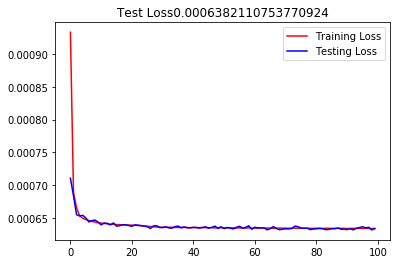

In [14]:
# Evaluate Accuracy
print('Training Loss:', np.mean(train_loss))
# print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
# print('Testing Accuracy:', test_accu[-1])
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss' + str(np.mean(val_loss)))
plt.legend()
plt.show()
# plt.plot(train_accu,'r', label='Training accuracy')
# plt.plot(test_accu,'b', label='Testing accuracy')
# plt.title('Test Accuracy : '+ str(test_accu[-1]))
# plt.legend()
# plt.show()

## Inferences
* After training the test and training errors went down to 0.000638. Which is below the critria of 0.01 percent.
* There is no overfitinng as such, therfore the netwrok can be claimed to work well.